# **Technical Appendix — Behavioral Experiment**

### Supplementary Materials for  
**“Who Leads the Trade? Responsibility, Algorithmic Influence, and Regret in Financial Human–Algorithm Collaboration”**

---

### **Author:**  
**Anna Kovalchuk**  
Zagreb, Croatia  
Email: kovalch.anna@gmail.com

---



### **Date:**  
February 2026

---

This Technical Appendix provides full methodological transparency for the behavioral experiment reported in the main manuscript.  
It includes:

- complete data‑processing steps  
- full model specifications for all models:
  - Responsibility Model
  - Influence Model  
  - Regret Model (Loss)  
  - Regret Model (Gain)  
- diagnostic checks  
- coefficient visualizations  
- marginal‑effects plots  
- variance‑decomposition metrics  
- power analysis  
- and all code required to reproduce the results  

All analyses were conducted in Python using `statsmodels`, `pandas`, `numpy`, `matplotlib`, and `seaborn`.


# 1. Setup, Imports, and Data Loading

This section initializes the replication environment. It performs the following steps:

### 1) Imports
Loads all required Python libraries for:
* Data processing (`pandas`, `numpy`)
* Visualization (`matplotlib`, `seaborn`)
* Statistical modelling (`statsmodels`)
* Diagnostics and utilities

### 2) Helper Functions
Defines a custom function (`get_lmm_r2_robust`) for computing marginal and conditional $R^2$ for Linear Mixed-Effects Models.

### 3) Load Raw Data
Reads the three datasets used in the study:
* `Market.xlsx`: Market results and algorithmic suggestions.
* `Trading_Study_Results.xlsx`: Participant decisions and outcomes.
* `prolific_demographic_export.xlsx`: Demographic and Prolific metadata.

### 4) Initial Cleaning
* Standardizes column formats.
* Removes duplicates.
* Merges datasets.
* Filters for **"APPROVED"** participants.
* Applies the attention check (**Round 12**).
* Constructs behavioural categories.

*Note: The input data has already been anonymized in accordance with GDPR requirements.*


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf
import statsmodels.api as sm
import scipy.stats as stats
from statsmodels.tools.tools import add_constant
from statsmodels.stats.outliers_influence import variance_inflation_factor
import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning
from statsmodels.stats.power import TTestPower

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore', ConvergenceWarning)

def get_lmm_r2_robust(model_result):
    """
    Calculates Marginal and Conditional R-squared for Linear Mixed-Effects Models 
    based on Nakagawa & Schielzeth (2013).
    """
    X = model_result.model.exog
    beta = model_result.fe_params
    predict_fixed = np.dot(X, beta)
    var_fixed = predict_fixed.var()
    
    cov_re = model_result.cov_re
    if hasattr(cov_re, 'iloc'):
        var_random = cov_re.values.diagonal().sum() 
    else:
        var_random = float(cov_re)
        
    var_resid = model_result.scale
    
    total_var = var_fixed + var_random + var_resid
    r2_marg = var_fixed / total_var
    r2_cond = (var_fixed + var_random) / total_var
    
    return r2_marg, r2_cond


df_market = pd.read_excel('Market.xlsx') 
df_results = pd.read_excel('Trading_Study_Results.xlsx')
df_demog = pd.read_excel("prolific_demographic_export.xlsx")

# Create explicit copies to avoid SettingWithCopyWarning
# 1. Market Data
df1 = df_market[['ticker', 'round', 'chart_move', 'Algo_suggest', 'start_price', 'final_price', 'Change_per']].copy()

# 2. Results Data (participant_id is already numeric)
df2 = df_results[['round', 'participant_id', 'initial_choice', 'initial_wager', 'final_choice', 'final_wager', 
                  'pnl','balance', 'regret', 'responsibility', 'influence']].copy()

# 3. Demographics Data
df3 = df_demog[['participant_id', 'Status', 'Types of investment', 'Age', 'Sex']].copy()

# --- DATA STANDARDIZATION -
df1['round'] = df1['round'].astype(int)
df2['round'] = df2['round'].astype(int)

# --- PROLIFIC FUNNEL METRICS ---
total_started = df3['participant_id'].nunique()
returned_n = len(df3[df3['Status'].str.upper() == 'RETURNED']) if 'Status' in df3.columns else 0
timeout_n = len(df3[df3['Status'].str.upper() == 'TIMED-OUT']) if 'Status' in df3.columns else 0

# Remove duplicates if any exist
df2 = df2.drop_duplicates(subset=['participant_id', 'round'])
df3 = df3.drop_duplicates(subset=['participant_id'])

# Metrics for raw data
raw_n = df2['participant_id'].nunique()
raw_rows = len(df2)

# --- MERGE DATASETS ---
# 1. Merge market data with participant results (on Round)
result_merge = pd.merge(df1, df2, on='round', how='left')
# 2. Merge with demographics (on Participant ID)
final_df = pd.merge(result_merge, df3, on='participant_id', how='left')

# --- DATA CLEANING & FILTERING ---
# Filter for 'APPROVED' participants only (if Status column exists)
if 'Status' in final_df.columns:
    final_df = final_df[final_df['Status'] == 'APPROVED'].copy()

# Ensure numeric types
for col in ['Age', 'pnl', 'responsibility', 'initial_wager', 'final_wager']:
    final_df[col] = pd.to_numeric(final_df[col], errors='coerce')

approved_ppl = final_df['participant_id'].nunique()
approved_rows = len(final_df)

# --- ATTENTION CHECK (ROUND 12) ---
# Participants were instructed to select 'SKIP' in Round 12.
# Those who failed to do so are excluded.
invalid_participants = final_df[
    (final_df['round'] == 12) & 
    (final_df['final_choice'].astype(str).str.strip().str.upper() != 'SKIP')
]['participant_id'].unique()

final_df = final_df[~final_df['participant_id'].isin(invalid_participants)]

final_ppl = final_df['participant_id'].nunique()
final_rows = len(final_df)

# --- BEHAVIOR CATEGORIZATION ---
# Classify decisions based on adherence to algorithm and position sizing
agree = (final_df['Algo_suggest'] == final_df['final_choice'])
oppose = (final_df['Algo_suggest'] != final_df['final_choice'])
inc = (final_df['final_wager'] > final_df['initial_wager'])
dec = (final_df['final_wager'] < final_df['initial_wager'])
stay = (final_df['final_wager'] == final_df['initial_wager'])

conditions = [(agree & inc), (agree & dec), (agree & stay),
              (oppose & inc), (oppose & dec), (oppose & stay)]
choices = ['Follow_Inc', 'Follow_Dec', 'Follow_Stay', 'Oppose_Inc', 'Oppose_Dec', 'Oppose_Stay']

final_df['behavior_type'] = np.select(conditions, choices, default='Other/Skip')
final_df['is_loss'] = (final_df['pnl'] < 0).astype(int)

# Create final working dataframe
df = final_df.copy()

print("PARTICIPANT FLOW SUMMARY (Attrition Analysis)")
print(f"Total started on Prolific:      {total_started}")
print(f"  - Returned by user:           {returned_n}")
print(f"  - Timed-out:                  {timeout_n}")
print("-" * 55)
print(f"1. Raw Data with results:       {raw_n} people, {raw_rows} rows")
print(f"2. After 'Approved' filter:     {approved_ppl} people, {approved_rows} rows")
print(f"3. Final (Attention Check):     {final_ppl} people, {final_rows} rows")
print("-" * 55)

PARTICIPANT FLOW SUMMARY (Attrition Analysis)
Total started on Prolific:      106
  - Returned by user:           4
  - Timed-out:                  2
-------------------------------------------------------
1. Raw Data with results:       100 people, 1500 rows
2. After 'Approved' filter:     100 people, 1500 rows
3. Final (Attention Check):     88 people, 1320 rows
-------------------------------------------------------


## 2. Advanced Feature Engineering and Transformations

This section describes the construction of all derived variables used in the statistical models and descriptive analyses.

### 1) Behavioural Decomposition
The composite variable `behavior_type` is decomposed into two interpretable components:

- **Adherence**  
  Indicates whether the algorithm’s recommendation was followed or opposed.

- **WagerChange**  
  Indicates whether the position size was increased, decreased, or maintained.

Both variables are encoded as categorical factors with explicitly defined level ordering to match the factorial structure used in the paper.

### 2) Standardization
To account for differences in market volatility across rounds:

- **P&L is standardized within each round** using a local z‑score.  
- **Wager magnitude** is standardized globally.

These transformations ensure comparability across heterogeneous market conditions.

### 3) Logit Transformations
Responsibility and Algorithm Influence, originally measured on a 0–100 scale, are converted to proportions and transformed using a logit function:

- `resp_logit` — logit‑transformed responsibility  
- `inf_logit` — logit‑transformed algorithm influence  

A small constant (`delta = 0.01`) is added to avoid boundary issues at the scale limits.

### 4) Additional Variables
The following variables are constructed:

- **is_loss** — binary indicator of negative P&L  
- **round_centered** — centered trial number to improve model stability  

### 5) Participant-Level Summary
Data are aggregated at the participant level to compute descriptive statistics for:

- Responsibility  
- Algorithm Influence  
- Regret  
- P&L  

These values correspond to the descriptive statistics reported in the Results section.

### 6) Final Cleaned Dataset
A cleaned dataset (`df_clean`) is produced by removing rows with missing values on key modelling variables.  
This dataset is used for all Linear Mixed‑Effects Models.


In [2]:
# ADVANCED FEATURE ENGINEERING
def split_behavior(val, part):
    if pd.isna(val) or '_' not in str(val): return None
    return str(val).split('_')[part]

df['Adherence'] = df['behavior_type'].apply(lambda x: split_behavior(x, 0))
df['WagerChange'] = df['behavior_type'].apply(lambda x: split_behavior(x, 1))

df['Adherence'] = df['Adherence'].astype('category').cat.set_categories(['Follow', 'Oppose'], ordered=False)
df['WagerChange'] = df['WagerChange'].astype('category').cat.set_categories(['Stay', 'Inc', 'Dec'], ordered=False)

# Local Z-score Standardization for PnL
# Standardizing PnL within each round to account for varying market volatility.
df['magnitude'] = df['final_wager']
df['magnitude_z'] = (df['magnitude'] - df['magnitude'].mean()) / df['magnitude'].std()
df['pnl_z'] = df.groupby('round')['pnl'].transform(lambda x: (x - x.mean()) / x.std())


delta = 0.01
# 1. Responsibility: scale 0-100 -> 0-1
df['resp_prop'] = df['responsibility'] / 100.0
# log((p + 0.01) / (1 - p + 0.01))
df['resp_logit'] = np.log((df['resp_prop'] + delta) / (1 - df['resp_prop'] + delta))

# 2. Influence: scale 0-100 -> 0-1
df['inf_prop'] = df['influence'] / 100.0
df['inf_logit'] = np.log((df['inf_prop'] + delta) / (1 - df['inf_prop'] + delta))

df['round_centered'] = df['round'] - df['round'].mean()


# SAMPLE CHARACTERISTICS (Descriptive Statistics)

# Aggregate data at the participant level to avoid overcounting repeated measures (N=86)
# We use raw scales (0-100) for reporting, as they are intuitive for readers.
participants_summary = df.groupby('participant_id').agg({
    'Age': 'first',
    'Sex': 'first',
    'responsibility': 'mean',
    'influence': 'mean',
    'regret': 'mean',
    'pnl': 'mean'
}).reset_index()

print("SUMMARY STATISTICS (N=" + str(len(participants_summary)) + ")")
print(f"Mean Age: {participants_summary['Age'].mean():.1f} (SD={participants_summary['Age'].std():.1f})")
print(f"\nGender Distribution:\n{participants_summary['Sex'].value_counts(normalize=True).round(3)}")
print("\nParticipant-level Means (Descriptive):")
print(participants_summary[['responsibility', 'influence', 'regret', 'pnl']].describe().round(2))

# DATA CLEANING
# Drop rows with missing values to prevent shape mismatch errors in LMM

cols_needed = ['resp_logit', 'inf_logit', 'Adherence', 'WagerChange', 'Age', 'participant_id']
df_clean = df.dropna(subset=cols_needed).copy()

SUMMARY STATISTICS (N=88)
Mean Age: 42.3 (SD=12.7)

Gender Distribution:
Sex
Male      0.648
Female    0.352
Name: proportion, dtype: float64

Participant-level Means (Descriptive):
       responsibility  influence  regret    pnl
count           88.00      88.00   88.00  88.00
mean            65.71      50.08    3.17  -1.98
std             21.28      21.97    1.20   4.18
min              3.57       0.00    1.00 -12.14
25%             49.82      37.70    2.27  -4.22
50%             68.64      51.79    3.25  -1.80
75%             78.88      66.39    3.88   0.46
max            100.00      93.21    6.14  13.59


## 3. Visualisation of Key Variables

This section presents the graphical summaries used to illustrate the main descriptive patterns reported in the paper.

### 1) Distributions of Responsibility and Algorithm Influence
Kernel‑smoothed histograms are generated to visualise the participant‑level distributions of:
- **Responsibility** (0–100 scale)
- **Algorithm Influence** (0–100 scale)

Both variables are plotted together to highlight differences in central tendency and dispersion.  
The resulting figure is exported as `distribution_plot.png`.

### 2) Responsibility by Behavioural Category
Mean responsibility scores are computed for each behavioural category derived from the experimental design.  
The categories are relabelled for readability and ordered to match the structure used in the manuscript.

A bar chart is produced to illustrate how perceived responsibility varies across:
- Follow vs. Oppose decisions  
- Increase, Decrease, or Maintain wager changes  

The figure is exported as `behavior_bar_chart.png`.

### 3) Plotting Settings
A consistent visual theme (`whitegrid`) and colour palette are applied to ensure clarity and reproducibility across all figures.


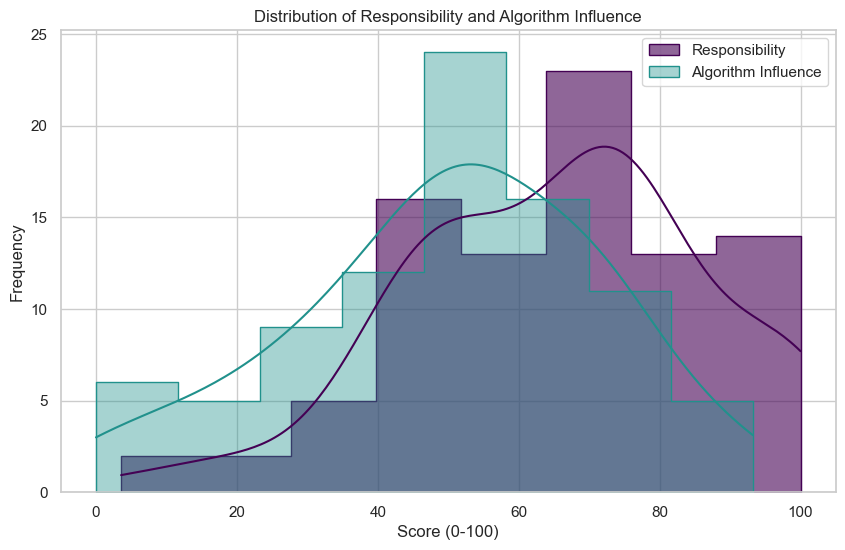

C:\Users\gorel\AppData\Local\Temp\ipykernel_21276\2470588356.py:35: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=plot_df, x='behavior_type', y='responsibility',


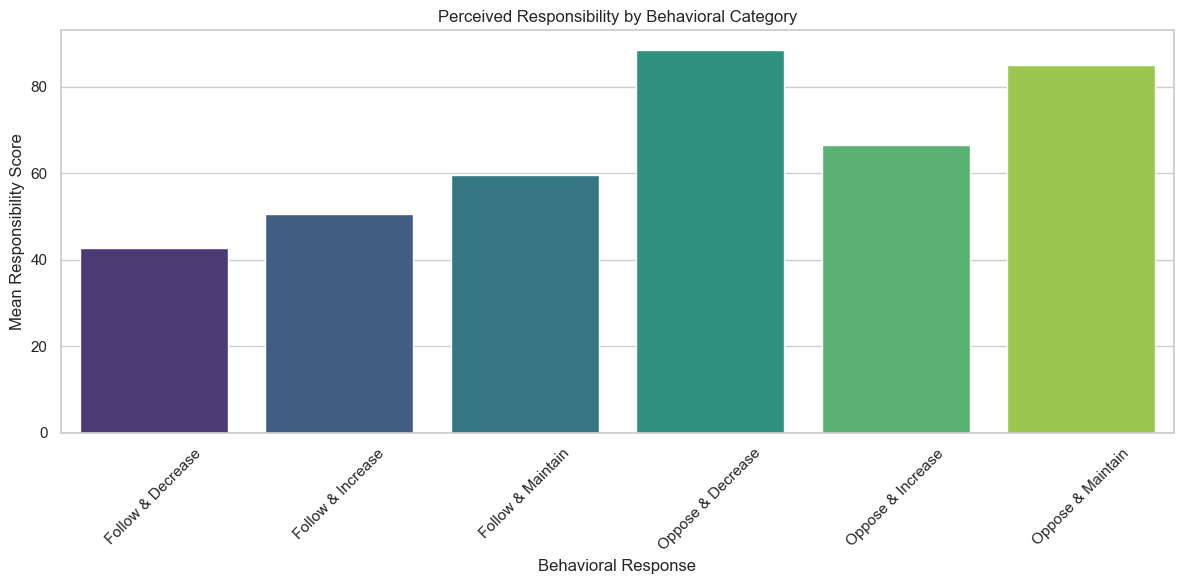

In [3]:
sns.set_theme(style="whitegrid")
main_color = "#440154"
alt_color = "#21918c"

plt.figure(figsize=(10, 6))
sns.histplot(participants_summary['responsibility'], color=main_color, 
             label="Responsibility", kde=True, element="step", alpha=0.6)
sns.histplot(participants_summary['influence'], color=alt_color, 
             label="Algorithm Influence", kde=True, element="step", alpha=0.4)

plt.legend()
plt.xlabel("Score (0-100)")
plt.ylabel("Frequency")
plt.title("Distribution of Responsibility and Algorithm Influence")
plt.savefig('distribution_plot.png', dpi=300, bbox_inches='tight')
plt.show()


plot_df = df.groupby('behavior_type', observed=True)['responsibility'].mean().reset_index()
plot_df = plot_df[plot_df['behavior_type'] != 'skip'].dropna()

rename_map = {
    'Follow_Dec': 'Follow & Decrease', 'Follow_Inc': 'Follow & Increase', 
    'Follow_Stay': 'Follow & Maintain', 'Oppose_Dec': 'Oppose & Decrease', 
    'Oppose_Inc': 'Oppose & Increase', 'Oppose_Stay': 'Oppose & Maintain'
}
plot_df['behavior_type'] = plot_df['behavior_type'].replace(rename_map)

target_order = [
    'Follow & Decrease', 'Follow & Increase', 'Follow & Maintain',
    'Oppose & Decrease', 'Oppose & Increase', 'Oppose & Maintain'
]

plt.figure(figsize=(12, 6))
sns.barplot(data=plot_df, x='behavior_type', y='responsibility', 
            palette='viridis', order=target_order)

plt.xticks(rotation=45)
plt.ylabel("Mean Responsibility Score")
plt.xlabel("Behavioral Response")
plt.title("Perceived Responsibility by Behavioral Category")
plt.tight_layout()

plt.savefig('behavior_bar_chart.png', dpi=300, bbox_inches='tight')
plt.show()

## 4. Correlation Analysis

This section presents the correlation structure among the key variables used in the study.

### 1) Variable Selection
A subset of variables is selected to examine their pairwise linear associations:

- Responsibility  
- Algorithm Influence  
- Regret  
- Final Wager  
- P&L Outcome  
- Trial Round  
- Participant Age  

These variables capture the core behavioural, emotional, and demographic dimensions of the dataset.

### 2) Correlation Matrix Computation
A Pearson correlation matrix is computed using the selected variables.  
Variable names are then relabelled for readability to match the terminology used in the manuscript.

### 3) Heatmap Visualisation
A heatmap is generated to display the correlation matrix, with:

- annotated correlation coefficients  
- a diverging colour palette centred at zero  
- fixed bounds from –1 to +1  

This visualisation highlights the strength and direction of associations among the study variables.  
The resulting figure is exported as `correlation_heatmap.png`.


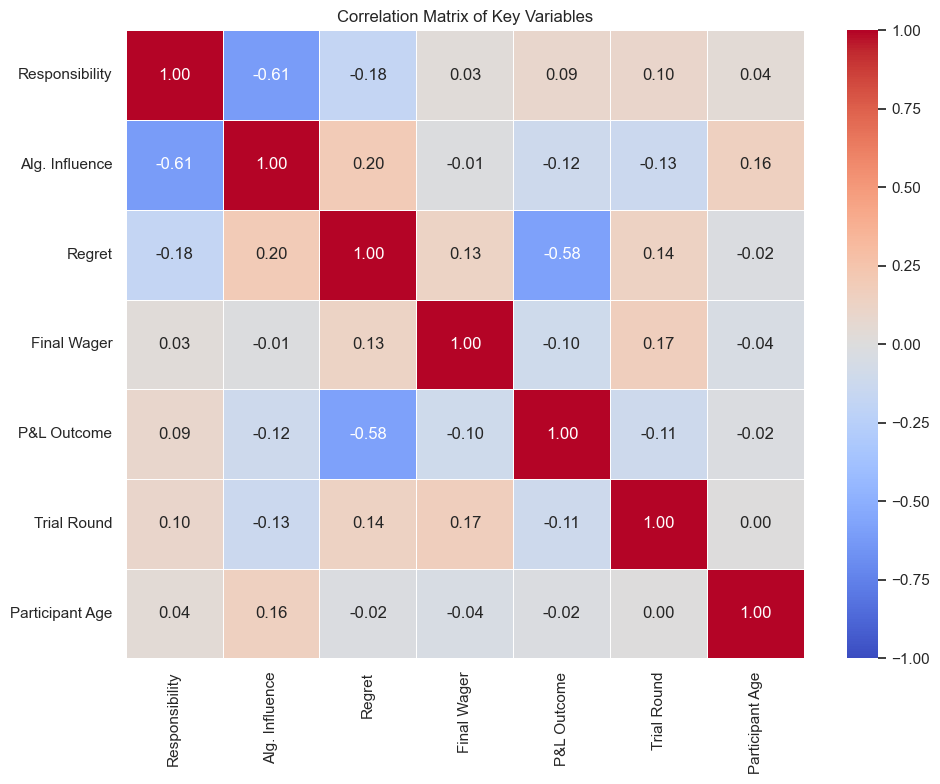

In [4]:
corr_cols = ['responsibility', 'influence', 'regret', 'final_wager', 'pnl', 'round', 'Age']
corr_data = df[corr_cols].corr()

rename_map = {
    'responsibility': 'Responsibility',
    'influence': 'Alg. Influence',
    'regret': 'Regret',
    'final_wager': 'Final Wager',
    'pnl': 'P&L Outcome',
    'round': 'Trial Round',
    'Age': 'Participant Age'
}

corr_data.columns = [rename_map.get(x, x) for x in corr_data.columns]
corr_data.index = [rename_map.get(x, x) for x in corr_data.index]

plt.figure(figsize=(10, 8))
sns.heatmap(corr_data, annot=True, cmap='coolwarm', fmt=".2f", 
            vmin=-1, vmax=1, center=0, linewidths=.5)

plt.title('Correlation Matrix of Key Variables')
plt.tight_layout()

plt.savefig('correlation_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()

## 5. Mixed-Effects Model: Responsibility (Factorial Design)

This section reports the estimation of the Linear Mixed-Effects Model used to analyse responsibility attribution.

### 1) Model Specification
A factorial model is estimated with:

- **Adherence** (Follow vs. Oppose)  
- **WagerChange** (Increase, Decrease, Maintain)  
- **Outcome Type** (Loss vs. Non-loss)  

as fixed effects, along with:

- **Trial number (centered)**  
- **Age**  
- **Sex**  

A random intercept and a random slope for the centered trial number are included for each participant.

### 2) Estimation Procedure
The model is fitted using Restricted Maximum Likelihood (REML) with the L-BFGS optimisation method.  
The dependent variable is the logit-transformed responsibility score (`resp_logit`).

### 3) Output
The full model summary is printed, including:

- fixed-effect estimates  
- random-effect variances  
- model fit statistics  

### 4) R² Computation
Marginal and conditional R² values are computed using a custom function:

- **Marginal R²** reflects variance explained by fixed effects  
- **Conditional R²** reflects variance explained by both fixed and random effects  

These values correspond to those reported in the Results section of the manuscript.


In [5]:
#  RESPONSIBILITY MODEL (FACTORIAL DESIGN)

formula_resp = "resp_logit ~ Adherence * WagerChange + C(is_loss) + round_centered + Age + Sex"
model_resp = smf.mixedlm(formula_resp, data=df_clean, groups="participant_id", re_formula="~round_centered")
res_resp = model_resp.fit(method=["lbfgs"])

print("RESULTS: RESPONSIBILITY MODEL")
print(res_resp.summary())

r2_m, r2_c = get_lmm_r2_robust(res_resp)
print(f"Marginal R2 (Design only): {r2_m:.3f}")
print(f"Conditional R2 (Design + Individual Diff): {r2_c:.3f}")

RESULTS: RESPONSIBILITY MODEL
                      Mixed Linear Model Regression Results
Model:                     MixedLM         Dependent Variable:         resp_logit
No. Observations:          1232            Method:                     REML      
No. Groups:                88              Scale:                      3.0617    
Min. group size:           14              Log-Likelihood:             -2583.9844
Max. group size:           14              Converged:                  Yes       
Mean group size:           14.0                                                  
---------------------------------------------------------------------------------
                                       Coef.  Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------------------------------
Intercept                               0.842    0.615  1.370 0.171 -0.363  2.048
Adherence[T.Oppose]                     1.983    0.134 14.775 0.000  1.720  2.246
WagerCha

## 6. Marginal Effects for Responsibility

This section reports the computation of marginal effects based on the fitted responsibility model.

### 1) Prediction Grid
A prediction dataset is constructed by taking all unique combinations of:

- behavioural category (`behavior_type`)  
- outcome type (`is_loss`)  
- adherence  
- wager change  

To isolate the effects of interest, the following values are held constant:

- **round_centered = 0**  
- **Age = sample mean**  
- **Sex = Male** (reference category)  
- **magnitude_z = 0**  

### 2) Model-Based Predictions
Predicted values of logit‑responsibility are generated using the fitted mixed‑effects model.  
These predictions are then transformed back to the 0–100 scale using the inverse logit function.

### 3) Baseline Comparison
A baseline condition is defined as:

- **Follow_Stay**  
- **Non-loss outcome (is_loss = 0)**  

Predicted responsibility for this condition is extracted, and all other predictions are expressed as differences relative to this baseline.

### 4) Output
The following results are printed:

- baseline predicted responsibility  
- predicted responsibility for each behavioural × outcome combination  
- difference from the baseline (in percentage points)  

These values correspond to the marginal effects reported in the manuscript.


In [6]:
print("CALCULATING MARGINAL EFFECTS (Interpretable %)")
def inverse_logit(x):
    return 1 / (1 + np.exp(-x))

pred_data = df_clean[['behavior_type', 'is_loss', 'Adherence', 'WagerChange']].drop_duplicates().copy()

pred_data['round_centered'] = 0 
pred_data['Age'] = df_clean['Age'].mean()
pred_data['Sex'] = 'Male' 
pred_data['magnitude_z'] = 0 

pred_data['pred_logit'] = res_resp.predict(pred_data)
pred_data['Predicted_Responsibility'] = inverse_logit(pred_data['pred_logit']) * 100

base_row = pred_data[
    (pred_data['behavior_type'] == 'Follow_Stay') & (pred_data['is_loss'] == 0)
]
base_val = base_row['Predicted_Responsibility'].values[0]
pred_data['Difference_from_Base'] = pred_data['Predicted_Responsibility'] - base_val


print(f"\nBASELINE (Follow_Stay, Win): {base_val:.2f}%")
print(" MARGINAL EFFECTS REPORT:")
cols = ['behavior_type', 'is_loss', 'Predicted_Responsibility', 'Difference_from_Base']
print(pred_data[cols].sort_values(by=['is_loss', 'Predicted_Responsibility'], ascending=[True, False]).round(2))

CALCULATING MARGINAL EFFECTS (Interpretable %)

BASELINE (Follow_Stay, Win): 78.03%
 MARGINAL EFFECTS REPORT:
    behavior_type  is_loss  Predicted_Responsibility  Difference_from_Base
5     Oppose_Stay        0                     96.27                 18.24
76     Oppose_Dec        0                     95.60                 17.57
2      Oppose_Inc        0                     86.95                  8.92
100   Follow_Stay        0                     78.03                  0.00
110    Follow_Inc        0                     68.35                 -9.68
132    Follow_Dec        0                     61.36                -16.67
0     Oppose_Stay        1                     93.39                 15.36
140    Oppose_Dec        1                     92.25                 14.22
29     Oppose_Inc        1                     78.49                  0.46
200   Follow_Stay        1                     66.06                -11.97
203    Follow_Inc        1                     54.19             

## 7. Coefficient Plot for the Responsibility Model

This section visualises the fixed‑effect estimates from the responsibility mixed‑effects model.

### 1) Extraction of Model Coefficients
Fixed‑effect estimates are extracted from the fitted model, excluding:

- the intercept  
- variance and covariance terms  

Corresponding confidence intervals are also extracted and aligned with the selected coefficients.

### 2) Relabelling for Interpretability
Coefficient names are relabelled to improve interpretability and to match the terminology used in the manuscript.  
This includes descriptive labels for:

- adherence effects  
- wager‑change effects  
- loss effects  
- demographic covariates  
- interaction terms  

### 3) Forest Plot Construction
A coefficient plot (forest plot) is generated, displaying:

- point estimates (log‑odds scale)  
- 95% confidence intervals  
- a vertical reference line at zero  

This visualisation highlights the relative contribution of each predictor to responsibility attribution.

### 4) Output
The resulting figure is exported as `responsibility_forest_plot.png` and corresponds to the coefficient visualisation reported in the manuscript.


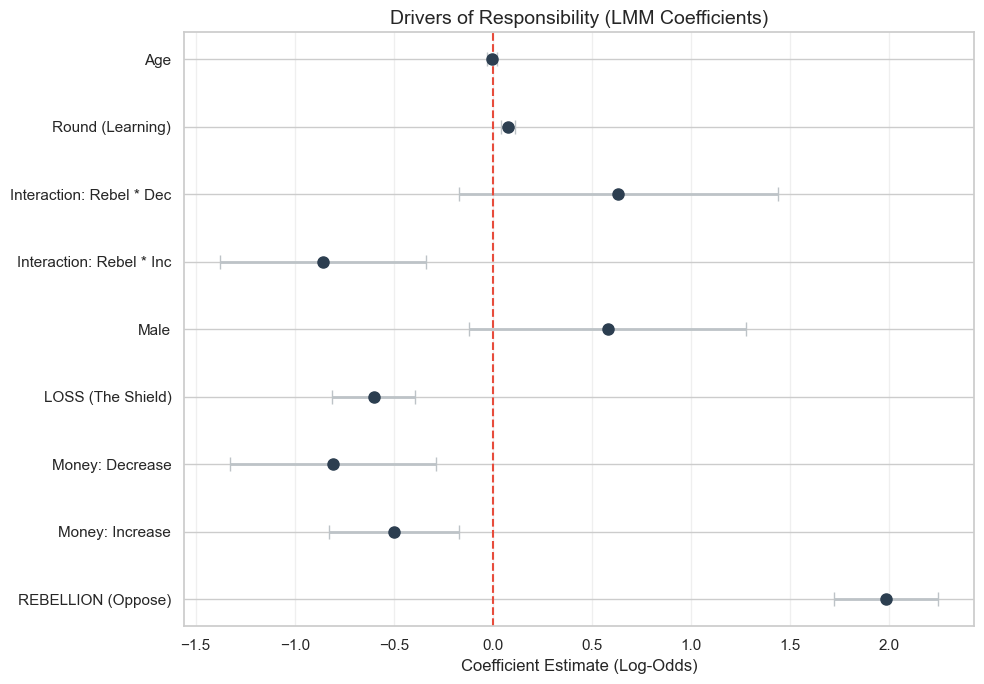

In [7]:
params = res_resp.params.drop('Intercept')
conf = res_resp.conf_int().drop('Intercept')
conf.columns = ['Lower', 'Upper']
params = params[~params.index.str.contains('Var|Cov')]
conf = conf[conf.index.isin(params.index)]

name_map = {
    'Adherence[T.Oppose]': 'REBELLION (Oppose)',
    'WagerChange[T.Inc]': 'Money: Increase',
    'WagerChange[T.Dec]': 'Money: Decrease',
    'C(is_loss)[T.1]': 'LOSS (The Shield)',
    'Sex[T.Male]': 'Male',
    'Age': 'Age',
    'round_centered': 'Round (Learning)',
    'Adherence[T.Oppose]:WagerChange[T.Inc]': 'Interaction: Rebel * Inc',
    'Adherence[T.Oppose]:WagerChange[T.Dec]': 'Interaction: Rebel * Dec'
}
plot_params = params.rename(index=name_map)
plot_conf = conf.rename(index=name_map)

plt.figure(figsize=(10, 7))
plt.errorbar(plot_params.values, plot_params.index, 
             xerr=[plot_params.values - plot_conf['Lower'], plot_conf['Upper'] - plot_params.values], 
             fmt='o', color='#2c3e50', ecolor='#bdc3c7', capsize=5, elinewidth=2, markersize=8)

plt.axvline(x=0, color='#e74c3c', linestyle='--', linewidth=1.5)
plt.title('Drivers of Responsibility (LMM Coefficients)', fontsize=14)
plt.xlabel('Coefficient Estimate (Log-Odds)', fontsize=12)
plt.grid(True, axis='x', alpha=0.3)
plt.tight_layout()

plt.savefig('responsibility_forest_plot.png', dpi=300, bbox_inches='tight')
plt.show()

## 8. Residual Diagnostics for the Responsibility Model

This section presents the diagnostic checks performed to evaluate the distributional assumptions of the responsibility mixed‑effects model.

### 1) Residual Extraction
Model residuals are extracted from the fitted responsibility model to assess:

- normality  
- symmetry  
- presence of outliers  

These diagnostics help verify whether the assumptions of the Linear Mixed‑Effects framework are reasonably satisfied.

### 2) Histogram of Residuals
A histogram is generated to visualise the empirical distribution of residuals.  
This plot provides an initial assessment of skewness, kurtosis, and overall shape.

### 3) Q–Q Plot
A Q–Q plot is produced to compare the residual distribution against a theoretical normal distribution.  
Deviations from the 45‑degree reference line indicate departures from normality.

### 4) Shapiro–Wilk Test
A formal Shapiro–Wilk test is conducted to statistically evaluate normality.  
The test reports:

- the W statistic  
- the associated p‑value  

These results complement the visual diagnostics and are reported in the manuscript as part of the model validation process.


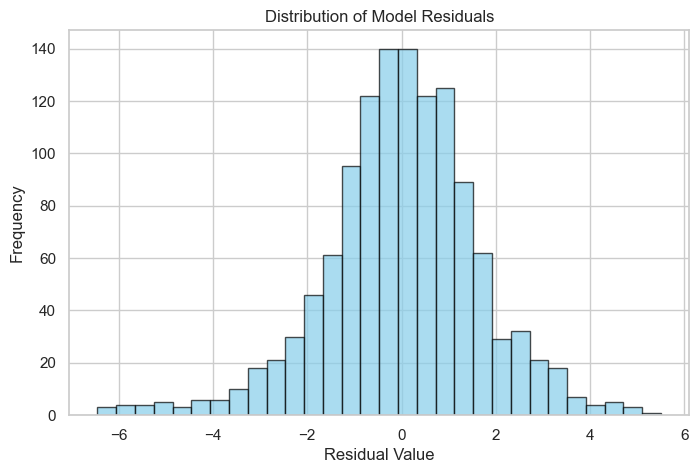

<Figure size 800x500 with 0 Axes>

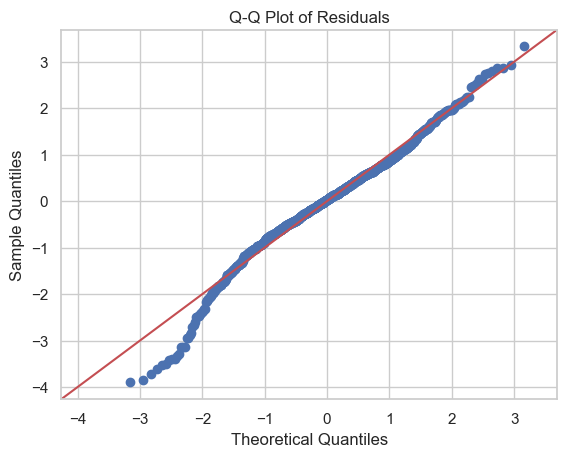

Shapiro-Wilk Test: Statistic=0.981, p-value=0.00000


In [8]:
residuals = res_resp.resid

# 2. HISTOGRAM 
plt.figure(figsize=(8, 5))
plt.hist(residuals, bins=30, edgecolor='black', color='skyblue', alpha=0.7)
plt.title('Distribution of Model Residuals')
plt.xlabel('Residual Value')
plt.ylabel('Frequency')
plt.show()

# 3. Q-Q PLOT
plt.figure(figsize=(8, 5))
# We use 'fit=True' and line='45' to compare against a standard normal distribution.
sm.qqplot(residuals, line='45', fit=True)
plt.title('Q-Q Plot of Residuals')
plt.show()

# 4. SHAPIRO-WILK TEST (Statistical Check)
shapiro_test = stats.shapiro(residuals)
print(f"Shapiro-Wilk Test: Statistic={shapiro_test.statistic:.3f}, p-value={shapiro_test.pvalue:.5f}")

## 9. Visualisation of Marginal Effects for Responsibility

This section presents a graphical summary of the marginal effects derived from the responsibility model.

### 1) Prediction Grid
A prediction dataset is constructed using all unique combinations of:

- Adherence  
- WagerChange  
- Outcome type (Loss vs. Win)  

To isolate the effects of interest, the following covariates are held constant:

- **round_centered = 0**  
- **Age = sample mean**  
- **Sex = Male**  

Predicted values are generated on the logit scale and transformed back to the 0–100 responsibility scale.

### 2) Behavioural Label Construction
A combined behavioural label is created by merging:

- adherence strategy  
- wager‑change direction  

This produces a compact and interpretable representation of each behavioural strategy.

### 3) Marginal Effects Plot
A point plot is generated to visualise predicted responsibility across behavioural strategies, separately for:

- **Win outcomes**  
- **Loss outcomes**  

Distinct markers, colours, and line styles are used to differentiate outcome types.  
A horizontal reference line is added to indicate the baseline condition:

- **Follow + Stay + Win**

### 4) Output
The resulting figure is exported as `responsibility_marginal_effects.png`.  
This plot corresponds to the marginal‑effects visualisation reported in the manuscript.


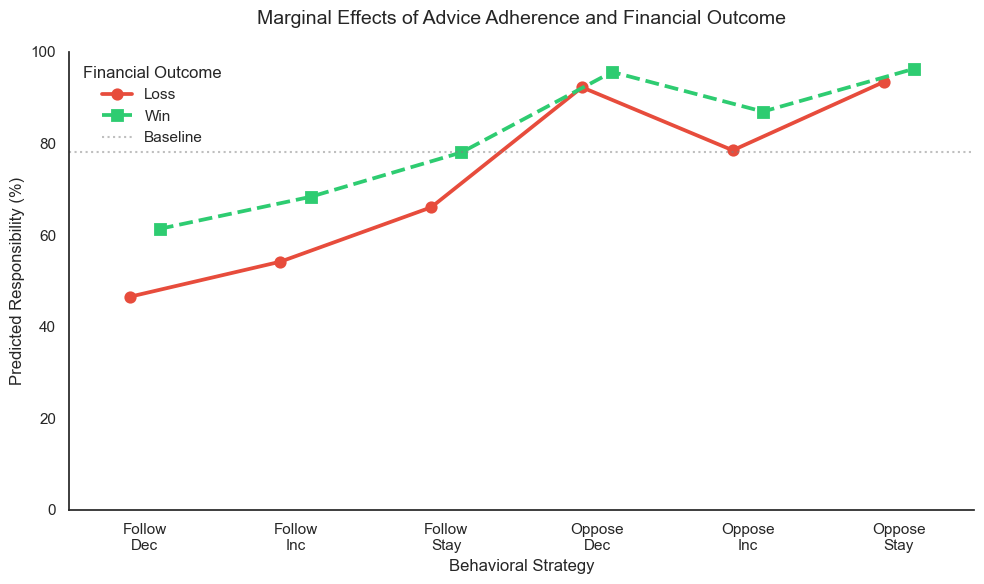

In [9]:
def inverse_logit(x):
    return 1 / (1 + np.exp(-x))

pred_resp = df_clean[['Adherence', 'WagerChange', 'is_loss']].drop_duplicates().copy()
pred_resp['round_centered'] = 0
pred_resp['Age'] = df_clean['Age'].mean()
pred_resp['Sex'] = 'Male' 

pred_resp['pred_logit'] = res_resp.predict(pred_resp)
pred_resp['Responsibility'] = inverse_logit(pred_resp['pred_logit']) * 100
pred_resp['Outcome'] = pred_resp['is_loss'].apply(lambda x: 'Loss' if x == 1 else 'Win')


def combine_names(row):
    return f"{row['Adherence']}\n{row['WagerChange']}"

pred_resp['behavior_clean'] = pred_resp.apply(combine_names, axis=1)


plt.figure(figsize=(10, 6))
sns.set_style("white") 


sns.pointplot(data=pred_resp, x='behavior_clean', y='Responsibility', 
              hue='Outcome', palette={'Win': '#2ecc71', 'Loss': '#e74c3c'}, 
              markers=['o', 's'], linestyles=['-', '--'], dodge=0.2,
              order=['Follow\nDec', 'Follow\nInc', 'Follow\nStay', 
                     'Oppose\nDec', 'Oppose\nInc', 'Oppose\nStay'])


plt.title('Marginal Effects of Advice Adherence and Financial Outcome', fontsize=14, pad=20)
plt.ylabel('Predicted Responsibility (%)', fontsize=12)
plt.xlabel('Behavioral Strategy', fontsize=12)
plt.ylim(0, 100)

# Baseline: Follow Stay + Win
base_val = pred_resp.loc[(pred_resp['Adherence']=='Follow') & 
                         (pred_resp['WagerChange']=='Stay') & 
                         (pred_resp['is_loss']==0), 'Responsibility'].values[0]
plt.axhline(base_val, color='gray', linestyle=':', alpha=0.5, label='Baseline')

sns.despine() 
plt.legend(title='Financial Outcome', frameon=False)
plt.tight_layout()


plt.savefig('responsibility_marginal_effects.png', dpi=300, bbox_inches='tight')
plt.show()

## 10. Effect Size, Multicollinearity, and Intraclass Correlation

This section reports additional diagnostics for the responsibility model, including effect size estimation, multicollinearity assessment, and intraclass correlation.

### 1) Pseudo‑R² (Nakagawa & Schielzeth, 2013)
Marginal and conditional R² values are computed using a variance‑decomposition approach:

- **Marginal R²** reflects variance explained solely by fixed effects  
- **Conditional R²** reflects variance explained by both fixed and random effects  

These metrics quantify the relative contributions of behavioural factors, outcome type, and individual differences.

### 2) Multicollinearity Check (VIF)
Variance Inflation Factors (VIFs) are calculated to assess multicollinearity among the fixed‑effect predictors.  
Categorical variables are dummy‑coded, and a constant term is added before computing VIF values.

### 3) Intraclass Correlation Coefficient (ICC)
The ICC is computed using:

- the random‑intercept variance  
- the residual variance  

This value represents the proportion of total variance attributable to stable individual differences across participants.

### 4) Output
The following results are printed:

- marginal and conditional R² values  
- VIF table  
- ICC estimate  

These diagnostics support the validity and interpretability of the mixed‑effects model.


In [10]:
def get_lmm_r2(model_result):
    """
    Calculates Nakagawa & Schielzeth's (2013) Pseudo-R2 for LMM.
    Safe version: Uses matrix multiplication instead of .predict() to avoid PatsyError.
    """
    # 1. Variance of Fixed Effects (X * beta)
    X = model_result.model.exog        # The design matrix (numbers)
    beta = model_result.fe_params      # The fixed effect coefficients
    predict_fixed = np.dot(X, beta)    # Matrix multiplication
    var_fixed = predict_fixed.var()
    
    # 2. Variance of Random Effects
    # We verify if cov_re is a dataframe or array and extract the Intercept Variance
    cov_re = model_result.cov_re
    if hasattr(cov_re, 'iloc'):
        var_random = float(cov_re.iloc[0, 0])
    else:
        var_random = float(cov_re[0, 0])      
    
    # 3. Variance of Residuals
    var_resid = model_result.scale
    
    # 4. Calculate R2
    total_var = var_fixed + var_random + var_resid
    r2_marginal = var_fixed / total_var
    r2_conditional = (var_fixed + var_random) / total_var
    
    return r2_marginal, r2_conditional

r2_marg, r2_cond = get_lmm_r2(res_resp)

print("EFFECT SIZE REPORT (Nakagawa's Pseudo-R2)")
print(f"1. Fixed Effects (Bot, Loss, Behavior): {r2_marg*100:.1f}% (Marginal R2)")
print(f"   (Role of external factors)")
print(f"2. Random Effects (Personality): {(r2_cond - r2_marg)*100:.1f}%")
print(f"   (Role of individual differences)")
print(f"3. TOTAL EXPLAINED VARIANCE: {r2_cond*100:.1f}% (Conditional R2)")

print(" CHECK: MULTICOLLINEARITY (VIF)")
X_vif = df_clean[['behavior_type', 'is_loss', 'round_centered', 'Age', 'Sex']].copy()

X_vif = pd.get_dummies(X_vif, drop_first=True)
X_vif = X_vif.astype(float)
X_vif = add_constant(X_vif)

vif_data = pd.DataFrame()
vif_data["Feature"] = X_vif.columns
vif_data["VIF"] = [variance_inflation_factor(X_vif.values, i) for i in range(len(X_vif.columns))]

print(vif_data.round(2))

print("CHECK: INTRACLASS CORRELATION (ICC)")
if hasattr(res_resp.cov_re, 'iloc'):
    var_intercept = float(res_resp.cov_re.iloc[0, 0])
else:
    var_intercept = float(res_resp.cov_re[0, 0])

var_residual = res_resp.scale

icc = var_intercept / (var_intercept + var_residual)

print(f"ICC Model: {icc:.3f}")

EFFECT SIZE REPORT (Nakagawa's Pseudo-R2)
1. Fixed Effects (Bot, Loss, Behavior): 19.5% (Marginal R2)
   (Role of external factors)
2. Random Effects (Personality): 34.0%
   (Role of individual differences)
3. TOTAL EXPLAINED VARIANCE: 53.5% (Conditional R2)
 CHECK: MULTICOLLINEARITY (VIF)
                     Feature    VIF
0                      const  36.02
1                    is_loss   1.04
2             round_centered   1.06
3                        Age   1.02
4   behavior_type_Follow_Inc   4.04
5  behavior_type_Follow_Stay   5.79
6   behavior_type_Oppose_Dec   1.64
7   behavior_type_Oppose_Inc   2.46
8  behavior_type_Oppose_Stay   5.05
9                   Sex_Male   1.04
CHECK: INTRACLASS CORRELATION (ICC)
ICC Model: 0.422


## 11. Mixed-Effects Model: Algorithmic Influence

This section reports the estimation of the Linear Mixed-Effects Model used to analyse perceived algorithmic influence.

### 1) Data Preparation
A cleaned dataset is constructed by removing rows with missing values on the variables required for modelling:

- logit-transformed influence (`inf_logit`)  
- behavioural category (`behavior_type`)  
- outcome type (`is_loss`)  
- centered trial number (`round_centered`)  
- demographic covariates (Age, Sex)  
- participant identifier  
- standardised wager magnitude (`magnitude_z`)  

The behavioural category is re‑encoded to set **Follow_Stay** as the reference group, allowing all other strategies to be interpreted relative to compliant behaviour.

### 2) Model Specification
A Linear Mixed-Effects Model is estimated with:

**Fixed effects:**
- behavioural category  
- outcome type (Loss vs. Win)  
- their interaction  
- centered trial number  
- Age  
- Sex  
- standardised wager magnitude  

**Random effects:**
- random intercepts for each participant  
- random slopes for trial number  

This structure accounts for repeated measures and individual learning trajectories.

### 3) Estimation Procedure
The model is fitted using the L-BFGS optimisation method.  
The dependent variable is the logit-transformed influence score (`inf_logit`).

### 4) Effect Size (Pseudo‑R²)
Marginal and conditional R² values are computed using the robust variance‑decomposition function:

- **Marginal R²** quantifies variance explained by fixed effects  
- **Conditional R²** quantifies variance explained by both fixed and random effects  

These values correspond to the effect-size metrics reported in the manuscript.


In [11]:
# DATA PREPARATION
cols_to_check = ['inf_logit', 'behavior_type', 'is_loss', 'round_centered', 'Age', 'Sex', 'participant_id', 'magnitude_z']
df_inf = df.dropna(subset=cols_to_check).copy()

# Establish 'Follow_Stay' (Compliance) as the baseline to compare other behaviors against
reference_group = 'Follow_Stay' 
df_inf['behavior_type'] = df_inf['behavior_type'].astype('category')
categories = [c for c in df_inf['behavior_type'].unique() if c != reference_group]
df_inf['behavior_type'] = df_inf['behavior_type'].cat.set_categories([reference_group] + categories, ordered=False)

# 3. FIT LINEAR MIXED MODEL (INFLUENCE)
# Fixed Effects: Behavior, Outcome (Loss), Magnitude, and Demographics
# Random Effects: Random Intercepts and Slopes (Time) per Participant to account for repeated measures
model_inf = smf.mixedlm("inf_logit ~ behavior_type * C(is_loss) + round_centered + Age + Sex + magnitude_z", 
                        data=df_inf, 
                        groups="participant_id",
                        re_formula="~round_centered") 

result_inf = model_inf.fit(method=["lbfgs"])
print(result_inf.summary())

r2_m, r2_c = get_lmm_r2_robust(result_inf)
print(f"Marginal R2 (Design only): {r2_m:.3f}")
print(f"Conditional R2 (Design + Individual Diff): {r2_c:.3f}")

                         Mixed Linear Model Regression Results
Model:                        MixedLM           Dependent Variable:           inf_logit 
No. Observations:             1232              Method:                       REML      
No. Groups:                   88                Scale:                        3.5626    
Min. group size:              14                Log-Likelihood:               -2672.5846
Max. group size:              14                Converged:                    Yes       
Mean group size:              14.0                                                      
----------------------------------------------------------------------------------------
                                             Coef.  Std.Err.    z    P>|z| [0.025 0.975]
----------------------------------------------------------------------------------------
Intercept                                    -1.143    0.586  -1.952 0.051 -2.290  0.005
behavior_type[T.Oppose_Stay]                 -2

## 12. Marginal Effects for Algorithmic Influence

This section presents the computation and visualisation of marginal effects derived from the influence model.

### 1) Prediction Grid
A prediction dataset is constructed using all unique combinations of:

- behavioural category (`behavior_type`)  
- outcome type (`is_loss`)  

To isolate the effects of interest, the following covariates are held constant:

- **round_centered = 0**  
- **Age = sample mean**  
- **Sex = Male**  
- **magnitude_z = 0**  

Predicted values are generated on the logit scale and transformed back to the 0–100 influence scale.

### 2) Behavioural Label Construction
Behavioural categories are relabelled to produce a compact and interpretable representation of:

- adherence strategy  
- wager‑change direction  

These labels are used to organise the marginal‑effects plot.

### 3) Marginal Effects Plot
A point plot is generated to visualise predicted influence across behavioural strategies, separately for:

- **Win outcomes**  
- **Loss outcomes**  

Distinct markers, colours, and line styles are used to differentiate outcome types.  
A horizontal reference line is added to indicate the baseline condition:

- **Follow_Stay + Win**

### 4) Output
The resulting figure is exported as `influence_marginal_effects.png`.  
This plot corresponds to the marginal‑effects visualisation reported in the manuscript.


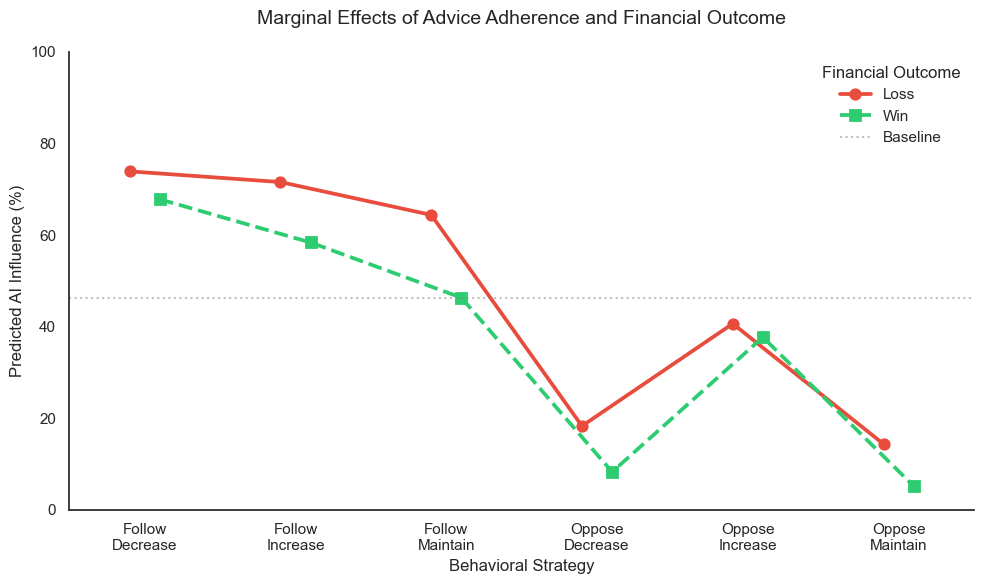

In [12]:
def inverse_logit(x):
    return 1 / (1 + np.exp(-x))

pred_inf = df_inf[['behavior_type', 'is_loss']].drop_duplicates().copy()
pred_inf['round_centered'] = 0
pred_inf['Age'] = df_inf['Age'].mean()
pred_inf['Sex'] = 'Male' 
pred_inf['magnitude_z'] = 0

pred_inf['pred_logit'] = result_inf.predict(pred_inf) 
pred_inf['Predicted_Influence'] = inverse_logit(pred_inf['pred_logit']) * 100
pred_inf['Outcome'] = pred_inf['is_loss'].apply(lambda x: 'Loss' if x == 1 else 'Win')

name_map = {
    'Follow_Stay': 'Follow\nMaintain',
    'Follow_Inc': 'Follow\nIncrease',
    'Follow_Dec': 'Follow\nDecrease',
    'Oppose_Stay': 'Oppose\nMaintain',
    'Oppose_Inc': 'Oppose\nIncrease',
    'Oppose_Dec': 'Oppose\nDecrease'
}
pred_inf['behavior_clean'] = pred_inf['behavior_type'].map(name_map)

plt.figure(figsize=(10, 6))
sns.set_style("white")

sns.pointplot(data=pred_inf, x='behavior_clean', y='Predicted_Influence', 
              hue='Outcome', palette={'Win': '#2ecc71', 'Loss': '#e74c3c'}, 
              markers=['o', 's'], linestyles=['-', '--'], dodge=0.2,
              order=['Follow\nDecrease', 'Follow\nIncrease', 'Follow\nMaintain', 
                     'Oppose\nDecrease', 'Oppose\nIncrease', 'Oppose\nMaintain'])

plt.title('Marginal Effects of Advice Adherence and Financial Outcome', fontsize=14, pad=20)
plt.ylabel('Predicted AI Influence (%)', fontsize=12)
plt.xlabel('Behavioral Strategy', fontsize=12)
plt.ylim(0, 100)

base_val = pred_inf.loc[(pred_inf['behavior_type']=='Follow_Stay') & (pred_inf['is_loss']==0), 'Predicted_Influence'].values[0]
plt.axhline(base_val, color='gray', linestyle=':', alpha=0.5, label='Baseline')

sns.despine()
plt.legend(title='Financial Outcome', frameon=False)
plt.tight_layout()

plt.savefig('influence_marginal_effects.png', dpi=300, bbox_inches='tight')
plt.show()

## 13. Coefficient Plot for the Influence Model

This section visualises the fixed‑effect estimates from the algorithmic influence mixed‑effects model.

### 1) Extraction of Model Coefficients
Fixed‑effect estimates are extracted from the fitted influence model, excluding:

- the intercept  
- variance and covariance terms  

Corresponding confidence intervals are also extracted and aligned with the selected coefficients.

### 2) Relabelling for Interpretability
Coefficient names are relabelled to improve interpretability and to match the terminology used in the manuscript.  
The relabelled terms include:

- behavioural effects  
- outcome effects (Loss vs. Win)  
- demographic covariates  
- wager‑magnitude effects  
- interaction terms between behaviour and outcome  

### 3) Forest Plot Construction
A coefficient plot (forest plot) is generated, displaying:

- point estimates (log‑odds scale)  
- 95% confidence intervals  
- a vertical reference line at zero  

This visualisation highlights the relative contribution of each predictor to perceived algorithmic influence.

### 4) Output
The resulting figure is exported as `influence_forest_plot.png`.  
This plot corresponds to the coefficient visualisation reported in the manuscript.


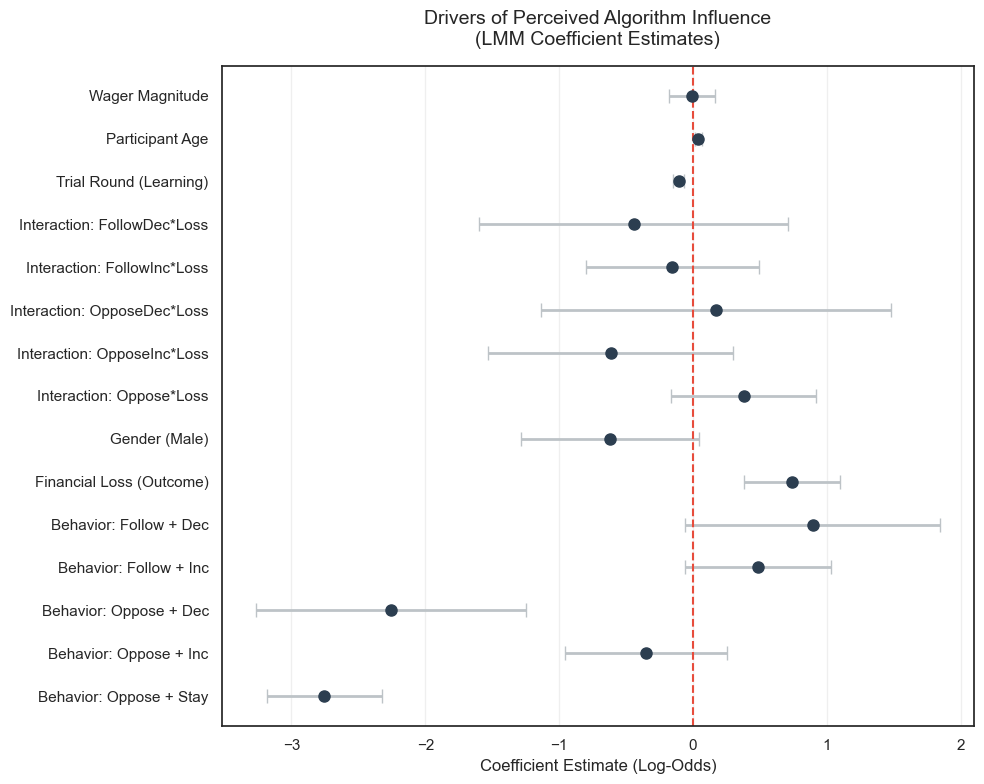

In [13]:
params_inf = result_inf.params.drop('Intercept')
conf_inf = result_inf.conf_int().drop('Intercept')
conf_inf.columns = ['Lower', 'Upper']


params_inf = params_inf[~params_inf.index.str.contains('Var|Cov')]
conf_inf = conf_inf[conf_inf.index.isin(params_inf.index)]


name_map_inf = {
    'behavior_type[T.Follow_Inc]': 'Behavior: Follow + Inc',
    'behavior_type[T.Follow_Dec]': 'Behavior: Follow + Dec',
    'behavior_type[T.Oppose_Stay]': 'Behavior: Oppose + Stay',
    'behavior_type[T.Oppose_Inc]': 'Behavior: Oppose + Inc',
    'behavior_type[T.Oppose_Dec]': 'Behavior: Oppose + Dec',
    'C(is_loss)[T.1]': 'Financial Loss (Outcome)', 
    'round_centered': 'Trial Round (Learning)',
    'Age': 'Participant Age',
    'Sex[T.Male]': 'Gender (Male)',
    'magnitude_z': 'Wager Magnitude',

    'behavior_type[T.Oppose_Stay]:C(is_loss)[T.1]': 'Interaction: Oppose*Loss',
    'behavior_type[T.Oppose_Inc]:C(is_loss)[T.1]': 'Interaction: OpposeInc*Loss',
    'behavior_type[T.Oppose_Dec]:C(is_loss)[T.1]': 'Interaction: OpposeDec*Loss',
    'behavior_type[T.Follow_Inc]:C(is_loss)[T.1]': 'Interaction: FollowInc*Loss',
    'behavior_type[T.Follow_Dec]:C(is_loss)[T.1]': 'Interaction: FollowDec*Loss'
}

plot_params_inf = params_inf.rename(index=name_map_inf)
plot_conf_inf = conf_inf.rename(index=name_map_inf)


plt.figure(figsize=(10, 8))

plt.errorbar(plot_params_inf.values, plot_params_inf.index, 
             xerr=[plot_params_inf.values - plot_conf_inf['Lower'], plot_conf_inf['Upper'] - plot_params_inf.values], 
             fmt='o', color='#2c3e50', ecolor='#bdc3c7', capsize=5, elinewidth=2, markersize=8)

plt.axvline(x=0, color='#e74c3c', linestyle='--', linewidth=1.5) 
plt.title('Drivers of Perceived Algorithm Influence\n(LMM Coefficient Estimates)', fontsize=14, pad=15)
plt.xlabel('Coefficient Estimate (Log-Odds)', fontsize=12)
plt.grid(True, axis='x', alpha=0.3)
plt.tight_layout()


plt.savefig('influence_forest_plot.png', dpi=300, bbox_inches='tight')
plt.show()

## 14. Residual Diagnostics and Effect Size for the Influence Model

This section presents diagnostic checks and effect‑size estimates for the algorithmic influence mixed‑effects model.

### 1) Residual Diagnostics
Model residuals are extracted to assess distributional assumptions.  
Two diagnostic plots are generated:

- **Histogram of residuals**, used to inspect skewness, kurtosis, and overall distribution shape  
- **Q–Q plot**, used to compare the empirical residual distribution against a theoretical normal distribution  

These diagnostics help evaluate whether the assumptions of the Linear Mixed‑Effects framework are reasonably satisfied.

### 2) Pseudo‑R² (Nakagawa & Schielzeth, 2013)
Marginal and conditional R² values are computed using a variance‑decomposition approach:

- **Marginal R²** quantifies variance explained by fixed effects  
- **Conditional R²** quantifies variance explained by both fixed and random effects  

Additional quantities are derived:

- variance explained by individual differences (random effects)  
- unexplained variance (residual noise)  

These metrics provide an interpretable effect‑size summary for the influence model.

### 3) Output
The following results are printed:

- residual diagnostics  
- marginal and conditional R² values  
- decomposition of explained variance  

These diagnostics support the robustness and interpretability of the influence model.


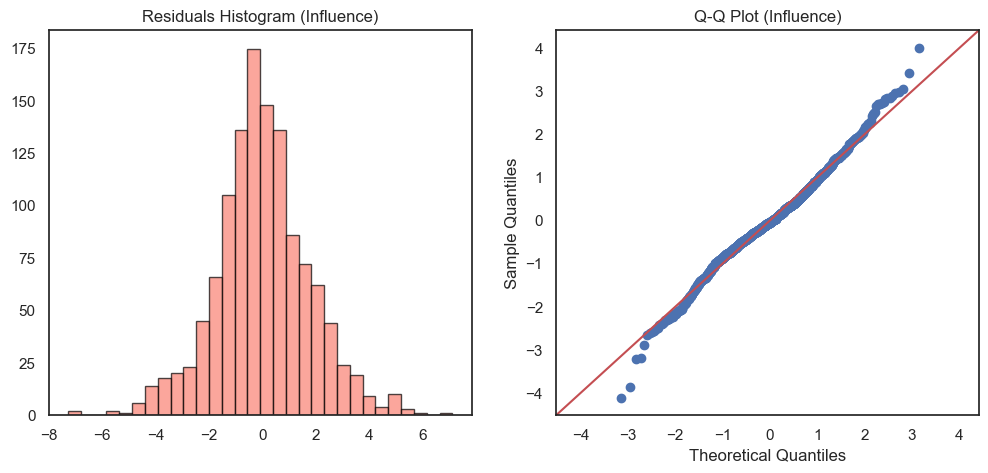

Marginal R2 (Design only): 0.194
Conditional R2 (Design + Individual Diff): 0.536


In [14]:
# DIAGNOSTICS
residuals = result_inf.resid

fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# Histogram
ax[0].hist(residuals, bins=30, edgecolor='black', color='salmon', alpha=0.7)
ax[0].set_title('Residuals Histogram (Influence)')

# Q-Q Plot
sm.qqplot(residuals, line='45', fit=True, ax=ax[1])
ax[1].set_title('Q-Q Plot (Influence)')
plt.show()

# R2 (EFFECT SIZE)
def get_lmm_r2(model_result):
    """
    Calculates Nakagawa & Schielzeth's (2013) Pseudo-R2 for LMM.
    Safe version: Uses matrix multiplication instead of .predict().
    """
    # Fixed Effects
    X = model_result.model.exog
    beta = model_result.fe_params
    predict_fixed = np.dot(X, beta)
    var_fixed = predict_fixed.var()
    
    # Random Effects
    cov_re = model_result.cov_re
    if hasattr(cov_re, 'iloc'):
        var_random = float(cov_re.iloc[0, 0])
    else:
        var_random = float(cov_re[0, 0])      
    
    # Residual Variance
    var_resid = model_result.scale
    
    # Calculate Ratios
    total_var = var_fixed + var_random + var_resid
    r2_marginal = var_fixed / total_var
    r2_conditional = (var_fixed + var_random) / total_var
    
    return r2_marginal, r2_conditional

# REPORT
current_model = result_inf 

r2_marg, r2_cond = get_lmm_r2(current_model)
explained_by_personality = r2_cond - r2_marg
unexplained_noise = 1.0 - r2_cond

r2_m, r2_c = get_lmm_r2_robust(res_resp)
print(f"Marginal R2 (Design only): {r2_m:.3f}")
print(f"Conditional R2 (Design + Individual Diff): {r2_c:.3f}")


## 15. Effect Size, Multicollinearity, and Intraclass Correlation for the Influence Model

This section reports additional diagnostics for the algorithmic influence model, including effect‑size estimation, multicollinearity assessment, and intraclass correlation.

### 1) Pseudo‑R² (Nakagawa & Schielzeth, 2013)
Marginal and conditional R² values are computed using a variance‑decomposition approach:

- **Marginal R²** reflects variance explained by fixed effects  
- **Conditional R²** reflects variance explained by both fixed and random effects  

The decomposition also quantifies:

- variance attributable to individual differences (random effects)  
- unexplained variance (residual noise)  

These metrics provide an interpretable effect‑size summary for the influence model.

### 2) Multicollinearity Check (VIF)
Variance Inflation Factors (VIFs) are calculated to assess multicollinearity among the fixed‑effect predictors.  
Categorical variables are dummy‑coded, converted to numeric format, and augmented with a constant term before VIF computation.

### 3) Intraclass Correlation Coefficient (ICC)
The ICC is computed using:

- the random‑intercept variance  
- the residual variance  

This value represents the proportion of total variance attributable to stable individual differences across participants.

### 4) Output
The following results are printed:

- marginal and conditional R² values  
- VIF table  
- ICC estimate  

These diagnostics support the robustness and interpretability of the influence model.


In [15]:
r2_marg_inf, r2_cond_inf = get_lmm_r2(result_inf)

print("EFFECT SIZE REPORT (Nakagawa's Pseudo-R2): INFLUENCE MODEL")
print(f"1. Fixed Effects (Bot, Loss, Behavior): {r2_marg_inf*100:.1f}% (Marginal R2)")
print(f"   (Role of external factors)")
print(f"2. Random Effects (Personality): {(r2_cond_inf - r2_marg_inf)*100:.1f}%")
print(f"   (Role of individual differences)")
print(f"3. TOTAL EXPLAINED VARIANCE: {r2_cond_inf*100:.1f}% (Conditional R2)")

print("\n CHECK: MULTICOLLINEARITY (VIF)")
X_vif_inf = df_inf[['behavior_type', 'is_loss', 'round_centered', 'Age', 'Sex']].copy()

X_vif_inf = pd.get_dummies(X_vif_inf, drop_first=True)
X_vif_inf = X_vif_inf.astype(float)
X_vif_inf = add_constant(X_vif_inf)

vif_data_inf = pd.DataFrame()
vif_data_inf["Feature"] = X_vif_inf.columns
vif_data_inf["VIF"] = [variance_inflation_factor(X_vif_inf.values, i) for i in range(len(X_vif_inf.columns))]

print(vif_data_inf.round(2))

print("\nCHECK: INTRACLASS CORRELATION (ICC)")
if hasattr(result_inf.cov_re, 'iloc'):
    var_intercept_inf = float(result_inf.cov_re.iloc[0, 0])
else:
    var_intercept_inf = float(result_inf.cov_re[0, 0])

var_residual_inf = result_inf.scale
icc_inf = var_intercept_inf / (var_intercept_inf + var_residual_inf)

print(f"ICC Model: {icc_inf:.3f}")

EFFECT SIZE REPORT (Nakagawa's Pseudo-R2): INFLUENCE MODEL
1. Fixed Effects (Bot, Loss, Behavior): 28.1% (Marginal R2)
   (Role of external factors)
2. Random Effects (Personality): 25.2%
   (Role of individual differences)
3. TOTAL EXPLAINED VARIANCE: 53.3% (Conditional R2)

 CHECK: MULTICOLLINEARITY (VIF)
                     Feature    VIF
0                      const  16.16
1                    is_loss   1.04
2             round_centered   1.06
3                        Age   1.02
4  behavior_type_Oppose_Stay   1.25
5   behavior_type_Oppose_Inc   1.17
6   behavior_type_Oppose_Dec   1.06
7   behavior_type_Follow_Inc   1.23
8   behavior_type_Follow_Dec   1.07
9                   Sex_Male   1.04

CHECK: INTRACLASS CORRELATION (ICC)
ICC Model: 0.351


## 16. Data Preparation for Regret Models

This section prepares the dataset used for modelling regret under gain and loss conditions.

### 1) Variable Selection and Cleaning
A subset of variables required for the regret analysis is selected:

- regret  
- behavioural category (`behavior_type`)  
- outcome type (`is_loss`)  
- centered trial number (`round_centered`)  
- demographic covariates (Age, Sex)  
- participant identifier  
- standardised wager magnitude (`magnitude_z`)  

Rows containing missing values on any of these variables are removed to ensure a complete dataset for model estimation.

### 2) Behavioural Category Encoding
The behavioural category is converted to a categorical factor, and **Follow_Stay** is set as the reference group.  
This ensures that all behavioural contrasts are interpreted relative to compliant behaviour.

### 3) Outcome-Specific Subsets
Two datasets are created to allow separate modelling of regret under different financial outcomes:

- **Loss dataset** — observations where `is_loss = 1`  
- **Gain dataset** — observations where `is_loss = 0`  

The sample sizes of both subsets are printed to document the number of observations available for each model.

### 4) Output
The resulting datasets (`df_loss` and `df_gain`) are used in the subsequent mixed‑effects models analysing regret under loss and gain conditions.


In [16]:
cols = ['regret', 'behavior_type', 'is_loss', 'round_centered', 'Age', 'Sex', 'participant_id', 'magnitude_z']
df_reg = df.dropna(subset=cols).copy()

ref_group = 'Follow_Stay'
df_reg['behavior_type'] = df_reg['behavior_type'].astype('category')
cats = [c for c in df_reg['behavior_type'].unique() if c != ref_group]
df_reg['behavior_type'] = df_reg['behavior_type'].cat.set_categories([ref_group] + cats, ordered=False)

df_loss = df_reg[df_reg['is_loss'] == 1].copy() 
df_gain = df_reg[df_reg['is_loss'] == 0].copy() 

print(f"   LOSS Dataset: N = {len(df_loss)} observations.")
print(f"   GAIN Dataset: N = {len(df_gain)} observations.")

   LOSS Dataset: N = 716 observations.
   GAIN Dataset: N = 516 observations.


## 17. R² Computation Function for Regret Models

This section defines the function used to compute marginal and conditional R² values for the regret models.

### 1) Variance Decomposition
The function implements the variance‑partitioning approach proposed by Nakagawa & Schielzeth (2013).  
The following components are extracted:

- **Fixed‑effect variance** — obtained via matrix multiplication of the design matrix and fixed‑effect coefficients  
- **Random‑effect variance** — extracted from the random‑intercept variance component  
- **Residual variance** — obtained from the model’s scale parameter  

### 2) R² Calculation
Two effect‑size metrics are computed:

- **Marginal R²** — proportion of variance explained by fixed effects  
- **Conditional R²** — proportion of variance explained by both fixed and random effects  

These metrics are used consistently across all regret models (gain and loss conditions).

### 3) Output
The function returns a tuple containing:

- marginal R²  
- conditional R²  

This function is used in subsequent sections to evaluate the explanatory power of the regret models.


In [17]:
def get_lmm_r2(model_result):
    X = model_result.model.exog
    beta = model_result.fe_params
    predict_fixed = np.dot(X, beta)
    var_fixed = predict_fixed.var()
    
    cov_re = model_result.cov_re
    if hasattr(cov_re, 'iloc'):
        var_random = float(cov_re.iloc[0, 0])
    else:
        var_random = float(cov_re[0, 0])
    
    var_resid = model_result.scale
    total_var = var_fixed + var_random + var_resid
    return var_fixed / total_var, (var_fixed + var_random) / total_var

## 18. Mixed-Effects Model: Regret Under Loss (Model A)

This section reports the estimation of the Linear Mixed-Effects Model used to analyse regret specifically in loss outcomes.

### 1) Model Specification
A mixed-effects model is estimated using only observations where a financial loss occurred (`is_loss = 1`).  
The dependent variable is **regret**, and the following predictors are included as fixed effects:

- behavioural category (`behavior_type`)  
- standardised wager magnitude (`magnitude_z`)  
- centered trial number (`round_centered`)  
- Age  
- Sex  

A random intercept is included for each participant to account for repeated measures.

### 2) Estimation Procedure
The model is fitted using the L-BFGS optimisation method.  
No random slopes are included in this specification, as the focus is on isolating behavioural and demographic predictors of regret under loss conditions.

### 3) Effect Size (Pseudo‑R²)
Marginal and conditional R² values are computed using the robust variance‑decomposition function:

- **Marginal R²** quantifies variance explained by fixed effects  
- **Conditional R²** quantifies variance explained by both fixed and random effects  

These metrics provide an interpretable summary of the explanatory power of the model.

### 4) Output
The following results are printed:

- full model summary  
- marginal and conditional R² values  

These results correspond to the loss‑specific regret analysis reported in the manuscript.


In [18]:
# 3. Model А: (LOSS PAIN)
# without random slopes
print("MODEL A: REGRET IN LOSS")
model_loss = smf.mixedlm("regret ~ behavior_type + magnitude_z + round_centered + Age + Sex", 
                         data=df_loss, 
                         groups="participant_id") 

res_loss = model_loss.fit(method=["lbfgs"])
print(res_loss.summary())
r2_m, r2_c = get_lmm_r2_robust(res_loss)
print(f"LOSS MODEL EFFECT SIZE")
print(f"Marginal R2 (Design only): {r2_m:.3f}")
print(f"Conditional R2 (Design + Individual Diff): {r2_c:.3f}")

MODEL A: REGRET IN LOSS
                 Mixed Linear Model Regression Results
Model:                 MixedLM      Dependent Variable:      regret    
No. Observations:      716          Method:                  REML      
No. Groups:            88           Scale:                   1.7767    
Min. group size:       3            Log-Likelihood:          -1340.6799
Max. group size:       12           Converged:               Yes       
Mean group size:       8.1                                             
-----------------------------------------------------------------------
                             Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-----------------------------------------------------------------------
Intercept                     5.020    0.654  7.679 0.000  3.738  6.301
behavior_type[T.Oppose_Stay] -0.209    0.130 -1.601 0.109 -0.464  0.047
behavior_type[T.Oppose_Inc]  -0.618    0.265 -2.331 0.020 -1.138 -0.098
behavior_type[T.Oppose_Dec]  -0.526    0.329 -1.596 0.111

## 19. Mixed-Effects Model: Regret Under Gains (Model B)

This section reports the estimation of the Linear Mixed-Effects Model used to analyse regret specifically in gain outcomes (the “FOMO” mechanism).

### 1) Model Specification
A mixed-effects model is estimated using only observations where a financial gain occurred (`is_loss = 0`).  
The dependent variable is **regret**, and the following predictors are included as fixed effects:

- behavioural category (`behavior_type`)  
- standardised wager magnitude (`magnitude_z`)  
- centered trial number (`round_centered`)  
- Age  
- Sex  

A random intercept is included for each participant to account for repeated measures.

### 2) Estimation Procedure
The model is fitted using the Powell optimisation method.  
Random slopes are not included in this specification to maintain comparability with the loss‑specific model and to isolate behavioural and demographic predictors of regret under gain conditions.

### 3) Effect Size (Pseudo‑R²)
Marginal and conditional R² values are computed using the robust variance‑decomposition function:

- **Marginal R²** quantifies variance explained by fixed effects  
- **Conditional R²** quantifies variance explained by both fixed and random effects  

These metrics provide an interpretable summary of the explanatory power of the gain‑specific regret model.

### 4) Output
The following results are printed:

- full model summary  
- marginal and conditional R² values  

These results correspond to the gain‑specific regret analysis reported in the manuscript.


In [19]:
print(" MODEL B: REGRET IN GAIN (The FOMO factor)")

# without random slopes
model_gain = smf.mixedlm("regret ~ behavior_type + magnitude_z + round_centered + Age + Sex", 
                         data=df_gain, 
                         groups="participant_id")

res_gain = model_gain.fit(method=["powell"]) 

print(res_gain.summary())
r2_m, r2_c = get_lmm_r2_robust(res_gain)
print(f"GAIN MODEL EFFECT SIZE")
print(f"Marginal R2 (Design only): {r2_m:.3f}")
print(f"Conditional R2 (Design + Individual Diff): {r2_c:.3f}")

 MODEL B: REGRET IN GAIN (The FOMO factor)
                 Mixed Linear Model Regression Results
Model:                  MixedLM      Dependent Variable:      regret   
No. Observations:       516          Method:                  REML     
No. Groups:             88           Scale:                   0.8106   
Min. group size:        2            Log-Likelihood:          -745.2065
Max. group size:        11           Converged:               Yes      
Mean group size:        5.9                                            
-----------------------------------------------------------------------
                             Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-----------------------------------------------------------------------
Intercept                     1.248    0.277  4.501 0.000  0.705  1.792
behavior_type[T.Oppose_Stay] -0.012    0.107 -0.113 0.910 -0.222  0.197
behavior_type[T.Oppose_Inc]   0.074    0.149  0.497 0.619 -0.218  0.366
behavior_type[T.Oppose_Dec]   0.450   

## 20. Coefficient Plots for Regret Models (Loss vs. Gain)

This section visualises the fixed‑effect estimates from the two regret models:

- **Model A:** Regret under loss outcomes  
- **Model B:** Regret under gain outcomes  

Both models are displayed side‑by‑side to facilitate direct comparison.

### 1) Extraction of Model Coefficients
For each model, fixed‑effect estimates are extracted, excluding:

- the intercept  
- variance and covariance terms  

Corresponding confidence intervals are also extracted and aligned with the selected coefficients.

### 2) Relabelling for Interpretability
Coefficient names are relabelled to improve interpretability and to match the terminology used in the manuscript.  
The relabelled terms include:

- behavioural effects  
- wager‑magnitude effects  
- learning effects (trial number)  
- demographic covariates  

### 3) Forest Plot Construction
A custom plotting function is used to generate forest plots for each model.  
Each subplot displays:

- point estimates (log‑odds scale)  
- 95% confidence intervals  
- a vertical reference line at zero  

Distinct colour schemes are used to differentiate the loss and gain models.

### 4) Output
The combined figure is exported as `regret_forest_plot.png`.  
This visualisation corresponds to the coefficient comparison reported in the manuscript.


<Figure size 1400x700 with 0 Axes>

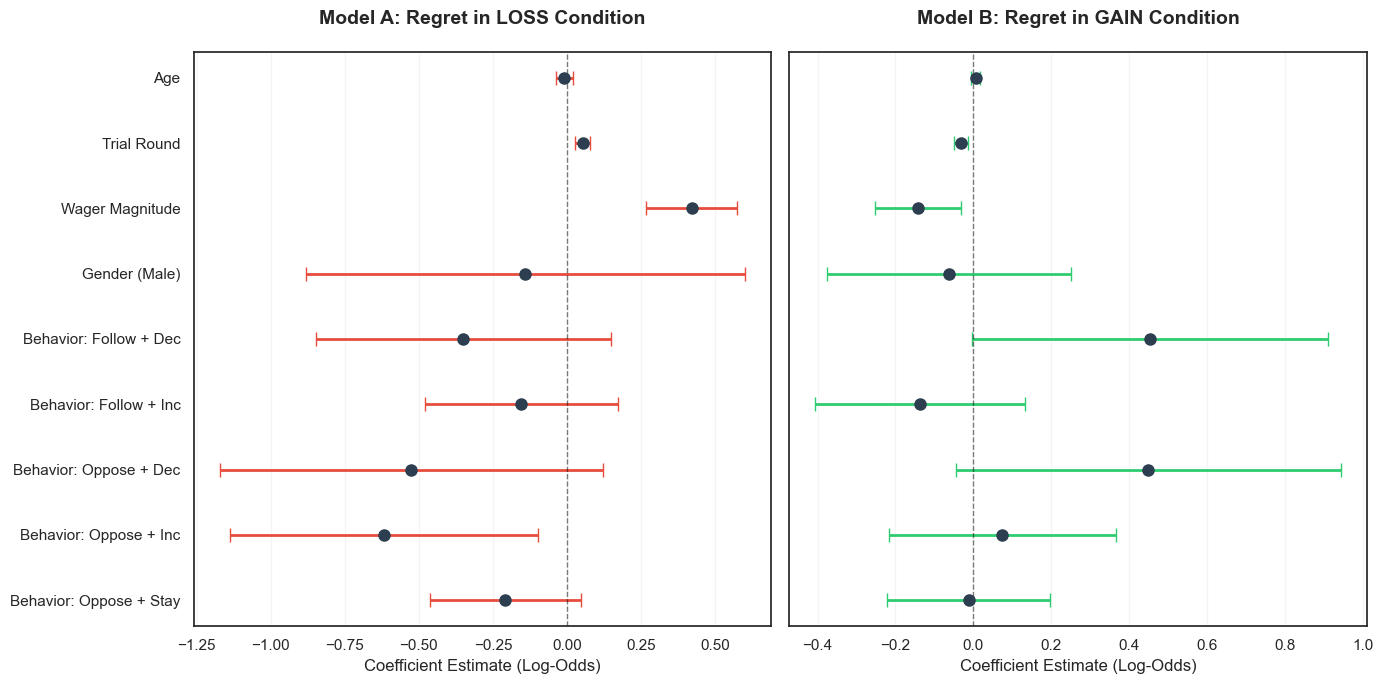

In [20]:
plt.figure(figsize=(14, 7))
fig, axes = plt.subplots(1, 2, figsize=(14, 7), sharey=True)

def draw_forest_subplot(model, ax, title, color):
    params = model.params.drop('Intercept')
    conf = model.conf_int().drop('Intercept')
    conf.columns = ['Lower', 'Upper']
    
    params = params[~params.index.str.contains('Var|Cov')]
    conf = conf[conf.index.isin(params.index)]
    
    name_map = {
        'behavior_type[T.Follow_Inc]': 'Behavior: Follow + Inc',
        'behavior_type[T.Follow_Dec]': 'Behavior: Follow + Dec',
        'behavior_type[T.Oppose_Stay]': 'Behavior: Oppose + Stay',
        'behavior_type[T.Oppose_Inc]': 'Behavior: Oppose + Inc',
        'behavior_type[T.Oppose_Dec]': 'Behavior: Oppose + Dec',
        'magnitude_z': 'Wager Magnitude',  
        'round_centered': 'Trial Round',
        'Age': 'Age',
        'Sex[T.Male]': 'Gender (Male)'
    }
    plot_params = params.rename(index=name_map)
    plot_conf = conf.rename(index=name_map)
    
    ax.errorbar(plot_params.values, plot_params.index, 
                xerr=[plot_params.values - plot_conf['Lower'], plot_conf['Upper'] - plot_params.values], 
                fmt='o', color='#2c3e50', ecolor=color, capsize=5, elinewidth=2, markersize=8)
    
    ax.axvline(x=0, color='black', linestyle='--', linewidth=1, alpha=0.5)
    
    ax.set_title(title, fontsize=14, fontweight='bold', pad=20)
    ax.set_xlabel('Coefficient Estimate (Log-Odds)', fontsize=12)
    ax.grid(True, axis='x', alpha=0.2)


# Model A: LOSS
draw_forest_subplot(res_loss, axes[0], "Model A: Regret in LOSS Condition", "#e74c3c")

# Model B: GAIN
draw_forest_subplot(res_gain, axes[1], "Model B: Regret in GAIN Condition", "#2ecc71")

plt.tight_layout()
plt.savefig('regret_forest_plot.png', dpi=300, bbox_inches='tight')
plt.show()

## 21. Model Diagnostics for Regret Models (Loss and Gain)

This section presents diagnostic checks and variance‑decomposition results for the two regret models:

- **Model A:** Regret under loss outcomes  
- **Model B:** Regret under gain outcomes  

A unified diagnostic function is used to ensure consistency across models.

### 1) Residual Diagnostics
For each model, residuals are extracted and visualised using:

- a **histogram**, which provides an overview of distributional shape, skewness, and potential outliers  
- a **Q–Q plot**, which compares the empirical residual distribution against a theoretical normal distribution  

These diagnostics help evaluate whether the assumptions of the Linear Mixed‑Effects framework are reasonably satisfied.

### 2) Pseudo‑R² (Nakagawa & Schielzeth, 2013)
Marginal and conditional R² values are computed using a variance‑partitioning approach:

- **Marginal R²** reflects variance explained by fixed effects  
- **Conditional R²** reflects variance explained by both fixed and random effects  

Additional quantities are derived:

- variance attributable to individual differences (random effects)  
- unexplained variance (residual noise)  

These metrics provide an interpretable effect‑size summary for both regret models.

### 3) Output
For each model (Loss and Gain), the following results are printed:

- residual histogram  
- Q–Q plot  
- marginal and conditional R² values  
- decomposition of explained variance  

These diagnostics support the robustness and interpretability of the regret models.


DIAGNOSTICS: LOSS Model


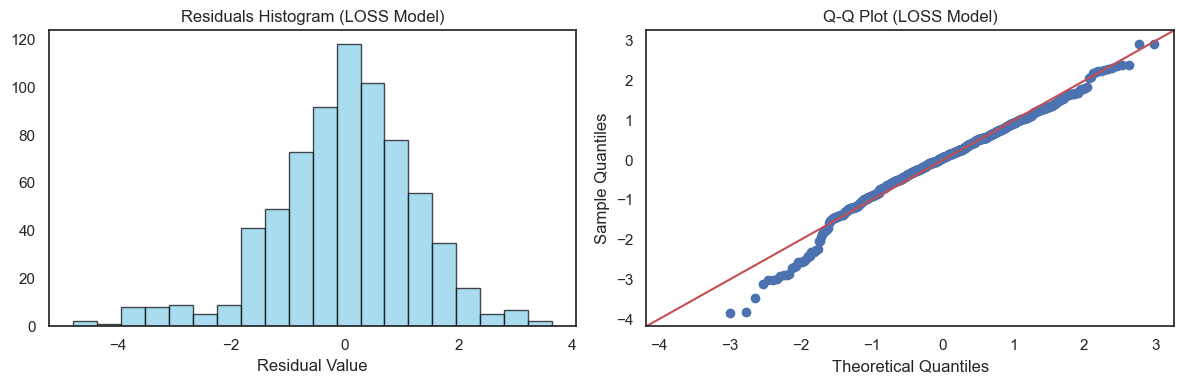

VARIANCE REPORT for LOSS Model:
1. SITUATION (Fixed Effects):  6.8%
2. PERSON (Random Effects):    55.3%
3. NOISE (Unexplained):        38.0%
TOTAL EXPLAINED:               62.0%
DIAGNOSTICS: GAIN Model


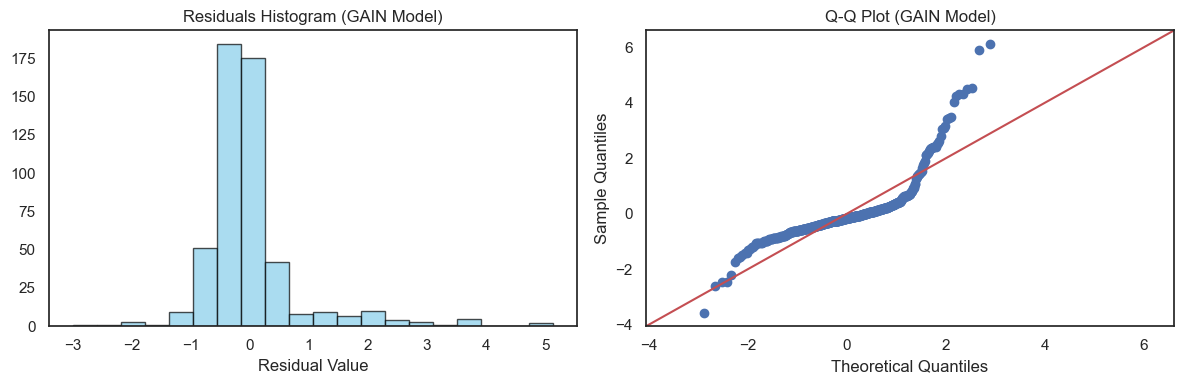

VARIANCE REPORT for GAIN Model:
1. SITUATION (Fixed Effects):  6.4%
2. PERSON (Random Effects):    28.6%
3. NOISE (Unexplained):        65.1%
TOTAL EXPLAINED:               34.9%


In [21]:
def get_lmm_r2(model_result):
    """
    Calculates Nakagawa & Schielzeth's (2013) Pseudo-R2.
    """
    # Fixed Effects
    X = model_result.model.exog
    beta = model_result.fe_params
    predict_fixed = np.dot(X, beta)
    var_fixed = predict_fixed.var()
    
    # Random Effects
    cov_re = model_result.cov_re
    if hasattr(cov_re, 'iloc'):
        var_random = float(cov_re.iloc[0, 0])
    else:
        var_random = float(cov_re[0, 0])      
    
    # Residuals
    var_resid = model_result.scale
    
    # Calculate
    total_var = var_fixed + var_random + var_resid
    r2_marginal = var_fixed / total_var
    r2_conditional = (var_fixed + var_random) / total_var
    return r2_marginal, r2_conditional

def check_model_health(model_res, model_name):
    print(f"DIAGNOSTICS: {model_name}")
    
    residuals = model_res.resid
    fig, ax = plt.subplots(1, 2, figsize=(12, 4))
    
    # Histogram
    ax[0].hist(residuals, bins=20, edgecolor='black', color='skyblue', alpha=0.7)
    ax[0].set_title(f'Residuals Histogram ({model_name})')
    ax[0].set_xlabel('Residual Value')
    
    # Q-Q Plot
    sm.qqplot(residuals, line='45', fit=True, ax=ax[1])
    ax[1].set_title(f'Q-Q Plot ({model_name})')
    
    plt.tight_layout()
    plt.show()
    
    # R2
    r2_m, r2_c = get_lmm_r2(model_res)
    expl_person = r2_c - r2_m
    noise = 1.0 - r2_c
    
    print(f"VARIANCE REPORT for {model_name}:")
    print(f"1. SITUATION (Fixed Effects):  {r2_m*100:.1f}%")
    print(f"2. PERSON (Random Effects):    {expl_person*100:.1f}%")
    print(f"3. NOISE (Unexplained):        {noise*100:.1f}%")
    print(f"TOTAL EXPLAINED:               {r2_c*100:.1f}%")

# LOSS
check_model_health(res_loss, "LOSS Model")

# GAIN (FOMO)
check_model_health(res_gain, "GAIN Model")

## 22. Effect Size, Multicollinearity, and ICC for Regret Models

This section reports effect‑size estimates, multicollinearity diagnostics, and intraclass correlation for the regret models under loss and gain conditions.  
A unified reporting function is used to ensure consistency across both analyses.

### 1) Pseudo‑R² (Nakagawa & Schielzeth, 2013)
Marginal and conditional R² values are computed using variance decomposition:

- **Marginal R²** reflects variance explained by fixed effects  
- **Conditional R²** reflects variance explained by both fixed and random effects  

The decomposition also quantifies:

- variance attributable to individual differences  
- unexplained variance (residual noise)  

These metrics provide an interpretable effect‑size summary for each regret model.

### 2) Multicollinearity Check (VIF)
Variance Inflation Factors (VIFs) are calculated to assess multicollinearity among the fixed‑effect predictors.  
The procedure includes:

- dummy‑coding categorical variables  
- converting all predictors to numeric format  
- adding a constant term  
- computing VIF values for each predictor  

This ensures that the fixed‑effect estimates are not distorted by collinearity.

### 3) Intraclass Correlation Coefficient (ICC)
The ICC is computed using:

- the random‑intercept variance  
- the residual variance  

This value represents the proportion of total variance attributable to stable individual differences across participants.

### 4) Output
For each model (Loss and Gain), the following results are printed:

- marginal and conditional R² values  
- VIF table  
- ICC estimate  

These diagnostics support the robustness and interpretability of the regret models.


In [22]:
def print_model_report(model_result, df_used, name):
    # 1. R2
    r2_m, r2_c = get_lmm_r2(model_result)
    
    print(f"\nEFFECT SIZE REPORT (Nakagawa's Pseudo-R2): {name}")
    print(f"1. Fixed Effects: {r2_m*100:.1f}% (Marginal R2)")
    print(f"2. Random Effects: {(r2_c - r2_m)*100:.1f}%")
    print(f"3. TOTAL EXPLAINED VARIANCE: {r2_c*100:.1f}% (Conditional R2)")

    # 2. VIF
    print(f"\n CHECK: MULTICOLLINEARITY (VIF) - {name}")
    X = df_used[['behavior_type', 'magnitude_z', 'round_centered', 'Age', 'Sex']].copy()
    X = pd.get_dummies(X, drop_first=True).astype(float)
    X = add_constant(X)
    vif = pd.DataFrame()
    vif["Feature"] = X.columns
    vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(len(X.columns))]
    print(vif.round(2))

    # 3. ICC
    var_int = float(model_result.cov_re.iloc[0, 0]) if hasattr(model_result.cov_re, 'iloc') else float(model_result.cov_re[0, 0])
    var_res = model_result.scale
    icc = var_int / (var_int + var_res)
    print(f"\nCHECK: INTRACLASS CORRELATION (ICC)")
    print(f"ICC Model: {icc:.3f}")


print_model_report(res_loss, df_loss, "REGRET IN LOSS")
print_model_report(res_gain, df_gain, "REGRET IN GAIN")


EFFECT SIZE REPORT (Nakagawa's Pseudo-R2): REGRET IN LOSS
1. Fixed Effects: 6.8% (Marginal R2)
2. Random Effects: 55.3%
3. TOTAL EXPLAINED VARIANCE: 62.0% (Conditional R2)

 CHECK: MULTICOLLINEARITY (VIF) - REGRET IN LOSS
                     Feature    VIF
0                      const  15.07
1                magnitude_z   1.12
2             round_centered   1.07
3                        Age   1.02
4  behavior_type_Oppose_Stay   1.24
5   behavior_type_Oppose_Inc   1.09
6   behavior_type_Oppose_Dec   1.08
7   behavior_type_Follow_Inc   1.23
8   behavior_type_Follow_Dec   1.14
9                   Sex_Male   1.06

CHECK: INTRACLASS CORRELATION (ICC)
ICC Model: 0.593

EFFECT SIZE REPORT (Nakagawa's Pseudo-R2): REGRET IN GAIN
1. Fixed Effects: 6.4% (Marginal R2)
2. Random Effects: 28.6%
3. TOTAL EXPLAINED VARIANCE: 34.9% (Conditional R2)

 CHECK: MULTICOLLINEARITY (VIF) - REGRET IN GAIN
                     Feature    VIF
0                      const  14.13
1                magnitude_z   1

## 23. Marginal Effects for Regret (Loss vs. Gain)

This section presents the marginal‑effects visualisation for regret under loss and gain conditions.  
Predicted regret scores are generated for each behavioural strategy while holding all covariates constant.

### 1) Prediction Grid
Two prediction datasets are constructed:

- **Loss condition** (`is_loss = 1`)  
- **Gain condition** (`is_loss = 0`)  

For both datasets, the following covariates are held constant:

- **magnitude_z = 0**  
- **round_centered = 0**  
- **Age = sample mean**  
- **Sex = Male**  

Predicted regret scores are obtained from the fitted loss and gain models.

### 2) Behavioural Label Construction
Behavioural categories are relabelled to produce a compact and interpretable representation of:

- adherence strategy  
- wager‑change direction  

These labels are used to organise the marginal‑effects plot.

### 3) Marginal Effects Plot
A point plot is generated to visualise predicted regret across behavioural strategies, separately for:

- **Loss outcomes**  
- **Gain outcomes**  

Distinct markers, colours, and line styles are used to differentiate outcome types.  
A horizontal reference line is added to indicate the baseline condition:

- **Follow_Stay + Win**

### 4) Output
The resulting figure is exported as `regret_marginal_effects.png`.  
This plot corresponds to the marginal‑effects visualisation reported in the manuscript.


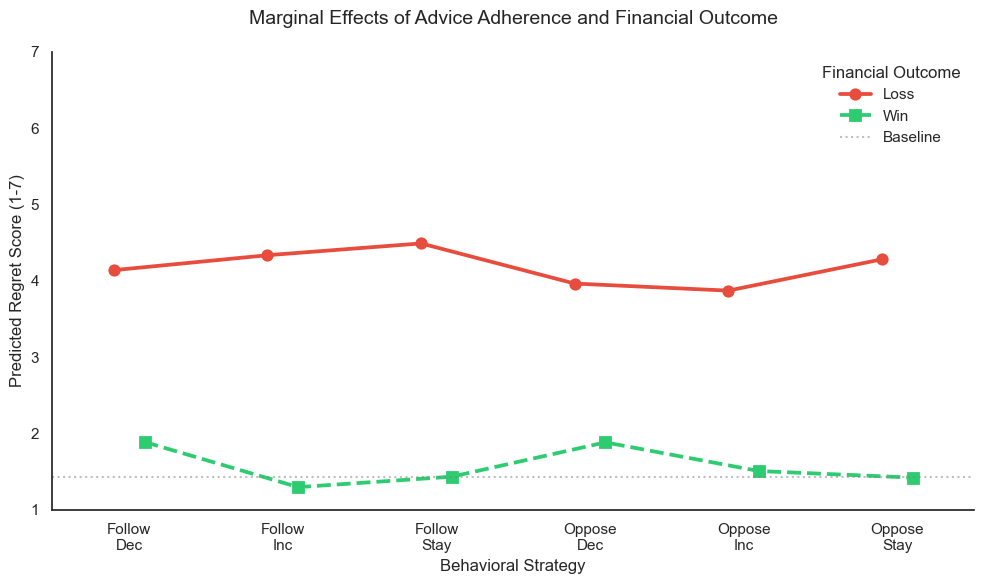

In [23]:
pred_loss = df_loss[['behavior_type']].drop_duplicates().copy()
pred_loss['is_loss'] = 1
pred_loss['magnitude_z'] = 0
pred_loss['round_centered'] = 0
pred_loss['Age'] = df_loss['Age'].mean()
pred_loss['Sex'] = 'Male'

pred_loss['Regret_Score'] = res_loss.predict(pred_loss)
pred_loss['Outcome'] = 'Loss'

pred_gain = df_gain[['behavior_type']].drop_duplicates().copy()
pred_gain['is_loss'] = 0
pred_gain['magnitude_z'] = 0
pred_gain['round_centered'] = 0
pred_gain['Age'] = df_gain['Age'].mean()
pred_gain['Sex'] = 'Male'

pred_gain['Regret_Score'] = res_gain.predict(pred_gain)
pred_gain['Outcome'] = 'Win'

plot_regret = pd.concat([pred_loss, pred_gain])

name_map = {
    'Follow_Stay': 'Follow\nStay',
    'Follow_Inc': 'Follow\nInc',
    'Follow_Dec': 'Follow\nDec',
    'Oppose_Stay': 'Oppose\nStay',
    'Oppose_Inc': 'Oppose\nInc',
    'Oppose_Dec': 'Oppose\nDec'
}
plot_regret['behavior_clean'] = plot_regret['behavior_type'].map(name_map)

plt.figure(figsize=(10, 6))
sns.set_style("white")

sns.pointplot(data=plot_regret, x='behavior_clean', y='Regret_Score', 
              hue='Outcome', palette={'Win': '#2ecc71', 'Loss': '#e74c3c'}, 
              markers=['o', 's'], linestyles=['-', '--'], dodge=0.2,
              order=['Follow\nDec', 'Follow\nInc', 'Follow\nStay', 
                     'Oppose\nDec', 'Oppose\nInc', 'Oppose\nStay'])

plt.title('Marginal Effects of Advice Adherence and Financial Outcome', fontsize=14, pad=20)
plt.ylabel('Predicted Regret Score (1-7)', fontsize=12)
plt.xlabel('Behavioral Strategy', fontsize=12)
plt.ylim(1, 7)

# Baseline: Follow Stay + Win
base_val = plot_regret.loc[(plot_regret['behavior_type']=='Follow_Stay') & 
                           (plot_regret['Outcome']=='Win'), 'Regret_Score'].values[0]
plt.axhline(base_val, color='gray', linestyle=':', alpha=0.5, label='Baseline')

sns.despine()
plt.legend(title='Financial Outcome', frameon=False)
plt.tight_layout()

plt.savefig('regret_marginal_effects.png', dpi=300, bbox_inches='tight')
plt.show()

## 24. A Priori Power Analysis

This calculation demonstrates that our pre-determined sample size of N=88 achieves 80% power for detecting effects of size d > 0.30
### 1) Power Analysis Parameters
The analysis is performed using the following specifications:

- **Significance level:** α = 0.05  
- **Statistical power:** 0.80  
- **Effect sizes (Cohen’s d):** 0.20, 0.30, 0.40, 0.50  

These values correspond to conventional benchmarks ranging from small to medium‑to‑large effects.

### 2) Required Sample Size
For each target effect size, the minimum required sample size is computed using the standard power function for the independent‑samples t‑test.  
The results are summarised in a table that includes:

- target effect size  
- required total sample size  
- qualitative interpretation of effect magnitude  

### 3) Detectable Effect Size for the Actual Sample
Given the study’s actual sample size (**N = 88**), the smallest effect size detectable with 80% power is calculated.  
This value provides a benchmark for interpreting the sensitivity of the study design.

### 4) Output
The following results are displayed:

- a table summarising required sample sizes for different effect sizes  
- the exact effect size detectable with N = 88  

These values correspond to the power analysis reported in the manuscript.


In [24]:
analysis = TTestPower()
alpha = 0.05
power = 0.80
effect_sizes = [0.2, 0.3, 0.4, 0.5]

# Calculate N for each effect size
required_n = [analysis.solve_power(effect_size=d, power=power, alpha=alpha) for d in effect_sizes]

# Create Table
df_power = pd.DataFrame({
    'Target Effect Size (d)': effect_sizes,
    'Required N': np.ceil(required_n).astype(int),
    'Interpretation': ['Small', 'Small-to-Medium', 'Medium', 'Medium-to-Large']
})

# Display
print("Table 1. A Priori Power Analysis (Alpha=0.05, Power=0.80)")
display(df_power)

# Calculate what N=88 specifically corresponds to
actual_d = analysis.solve_power(effect_size=None, power=power, alpha=alpha, nobs=88)
print(f"\nNote: With N=88, the exact detectable effect size is d = {actual_d:.3f}")

Table 1. A Priori Power Analysis (Alpha=0.05, Power=0.80)


,Target Effect Size (d),Required N,Interpretation
0,0.2,199,Small
1,0.3,90,Small-to-Medium
2,0.4,52,Medium
3,0.5,34,Medium-to-Large



Note: With N=88, the exact detectable effect size is d = 0.302
